# Data Scrapping

Im ersten Notebook besteht das Ziel darin, die Informationen zu den Fahrzeugangeboten der ausgewählten Automarken auf Autoscout24 zu erfassen. Die ausgewählten Automarken sind die am häufigsten angebotenen Marken auf Autoscout24. Es handelt sich um Mercedes-Benz, Porsche, BMW, Audi, Opel und Volkswagen (VW). Nachdem die Daten für jede Marke erhalten wurden, werden die Daten aller sechs Marken in ein DataFrame zusammengeführt. Schließlich werden einige grundlegende Datenaufbereitungen durchgeführt, einschließlich der Behandlung von fehlenden Daten.

In [2]:
from bs4 import BeautifulSoup, SoupStrainer #HTML parsing
import urllib.request #aufrufen von URLs
from time import sleep #damit legen wir den Scraper schlafen
import json #lesen und schreiben von JSON-Dateien
from datetime import datetime #um den Daten Timestamps zu geben
import re #regular expressions
import os #Dateipfade erstellen und lesen
import pandas as pd #Datenanalyse und -manipulation

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install required libraries
!pip install beautifulsoup4 lxml pandas requests

# Mercedes-Benz

Der vorliegende Code dient dazu, systematisch Informationen über gebrauchte Autos einer bestimmten Marke von AutoScout24.de zu sammeln. Hierbei durchläuft er eine Liste von Automodellen, besucht die zugehörigen Seiten und extrahiert Daten zu den gelisteten Autos. Nach jeweils 10 Modellen werden die gesammelten Informationen in einer CSV-Datei zwischengespeichert, die auf Google Drive heruntergeladen wird. Dieser Prozess wiederholt sich, bis alle Modelle durchlaufen sind. Am Ende werden alle Daten zusammengeführt, um einen umfassenden Datensatz zu erstellen. Der Code gibt dabei regelmäßig Auskunft über den Fortschritt und integriert kurze Pausen, um die Website nicht zu überlasten.

In [20]:
car_models = """
170,
180,
190,
200,
208,
220,
230,
240,
250,
260,
270,
280,
300,
308,
320,
350,
380,
400,
416,
420,
450,
500,
560,
600,
A 140,
A 150,
A 160,
A 170,
A 180,
A 190,
A 200,
A 210,
A 220,
A 250,
A 35 AMG,
A 45 AMG,
Actros,
AMG GT,
Atego,
B 150,
B 160,
B 170,
B 180,
B 200,
B 220,
B 250,
B Electric Drive,
C 160,
C 180,
C 200,
C 220,
C 230,
C 240,
C 250,
C 270,
C 280,
C 30 AMG,
C 300,
C 32 AMG,
C 320,
C 350,
C 36 AMG,
C 400,
C 43 AMG,
C 450,
C 55 AMG,
C 63 AMG,
CE 200,
CE 220,
CE 230,
CE 280,
CE 300,
Citan,
CL,
CL 160,
CL 180,
CL 200,
CL 220,
CL 230,
CL 320,
CL 420,
CL 500,
CL 55 AMG,
CL 600,
CL 63 AMG,
CL 65 AMG,
CLA 180,
CLA 200,
CLA 220,
CLA 250,
CLA 35 AMG,
CLA 45 AMG,
CLC,
CLE,
CLE 200,
CLE 220,
CLE 300,
CLK,
CLK 200,
CLK 220,
CLK 230,
CLK 240,
CLK 270,
CLK 280,
CLK 320,
CLK 350,
CLK 430,
CLK 500,
CLK 55 AMG,
CLK 63 AMG,
CLS,
CLS 220,
CLS 250,
CLS 280,
CLS 300,
CLS 320,
CLS 350,
CLS 400,
CLS 450,
CLS 500,
CLS 53 AMG,
CLS 55 AMG,
CLS 63 AMG,
E 200,
E 220,
E 230,
E 240,
E 250,
E 260,
E 270,
E 280,
E 290,
E 300,
E 320,
E 350,
E 36 AMG,
E 400,
E 420,
E 43 AMG,
E 430,
E 450,
E 50 AMG,
E 500,
E 53 AMG,
E 55 AMG,
E 550,
E 60 AMG,
E 63 AMG,
EQA,
EQA 250,
EQA 300,
EQA 350,
EQB 250,
EQB 300,
EQB 350,
EQC 400,
EQE 300,
EQE 350,
EQE 43,
EQE 500,
EQE 53,
EQE SUV,
EQS,
EQS SUV,
EQT,
EQV 250,
EQV 300,
G,
G 230,
G 240,
G 250,
G 270,
G 280,
G 290,
G 300,
G 320,
G 350,
G 400,
G 500,
G 55 AMG,
G 63 AMG,
G 65 AMG,
G 650,
GL 320,
GL 350,
GL 400,
GL 420,
GL 450,
GL 500,
GL 55 AMG,
GL 63 AMG,
GLA 180,
GLA 200,
GLA 220,
GLA 250,
GLA 35 AMG,
GLA 45 AMG,
GLB 180,
GLB 200,
GLB 220,
GLB 250,
GLB 35 AMG,
GLC 200,
GLC 220,
GLC 250,
GLC 300,
GLC 350,
GLC 400,
GLC 43 AMG,
GLC 63 AMG,
GLE 250,
GLE 300,
GLE 350,
GLE 400,
GLE 43 AMG,
GLE 450,
GLE 500,
GLE 53 AMG,
GLE 580,
GLE 63 AMG,
GLK 200,
GLK 220,
GLK 250,
GLK 280,
GLK 300,
GLK 320,
GLK 350,
GLS 350,
GLS 400,
GLS 450,
GLS 500,
GLS 580,
GLS 600,
GLS 63 AMG,
ML 230,
ML 250,
ML 270,
ML 280,
ML 300,
ML 320,
ML 350,
ML 400,
ML 420,
ML 430,
ML 450,
ML 500,
ML 55 AMG,
ML 63 AMG,
Marco Polo,
Maybach GLS,
Maybach S-Klasse,
MB 100,
R 280,
R 300,
R 320,
R 350,
R 500,
R
"""

# Konvertiere den String in eine Liste, entferne leere Strings und bearbeite jeden Modellnamen
car_model_list = [model.strip(',').lower().replace(' ', '-') for model in car_models.split('\n') if model]

# Zeige jeden Modellnamen als eigenen String in der Liste an
for model in car_model_list:
    print(model)

170
180
190
200
208
220
230
240
250
260
270
280
300
308
320
350
380
400
416
420
450
500
560
600
a-140
a-150
a-160
a-170
a-180
a-190
a-200
a-210
a-220
a-250
a-35-amg
a-45-amg
actros
amg-gt
atego
b-150
b-160
b-170
b-180
b-200
b-220
b-250
b-electric-drive
c-160
c-180
c-200
c-220
c-230
c-240
c-250
c-270
c-280
c-30-amg
c-300
c-32-amg
c-320
c-350
c-36-amg
c-400
c-43-amg
c-450
c-55-amg
c-63-amg
ce-200
ce-220
ce-230
ce-280
ce-300
citan
cl
cl-160
cl-180
cl-200
cl-220
cl-230
cl-320
cl-420
cl-500
cl-55-amg
cl-600
cl-63-amg
cl-65-amg
cla-180
cla-200
cla-220
cla-250
cla-35-amg
cla-45-amg
clc
cle
cle-200
cle-220
cle-300
clk
clk-200
clk-220
clk-230
clk-240
clk-270
clk-280
clk-320
clk-350
clk-430
clk-500
clk-55-amg
clk-63-amg
cls
cls-220
cls-250
cls-280
cls-300
cls-320
cls-350
cls-400
cls-450
cls-500
cls-53-amg
cls-55-amg
cls-63-amg
e-200
e-220
e-230
e-240
e-250
e-260
e-270
e-280
e-290
e-300
e-320
e-350
e-36-amg
e-400
e-420
e-43-amg
e-430
e-450
e-50-amg
e-500
e-53-amg
e-55-amg
e-550
e-60-amg
e-63-amg


In [6]:
# Import necessary libraries
import os
import json
import re
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup
import requests
from time import sleep

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Update file paths for Google Drive
base_path =  "/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/"
visited_folder = base_path + "data/visited/"
autos_folder = base_path + "data/autos/"

# Create folders if they don't exist
for folder in [visited_folder, autos_folder]:
    if not os.path.isdir(folder):
        os.makedirs(folder)
        print(folder, "created.")
    else:
        print(folder, "already exists")

# Path to visited URLs
path_to_visited_urls = visited_folder + "visited_urls.json"

# Create visited_urls.json if it doesn't exist
if not os.path.isfile(path_to_visited_urls):
    with open(path_to_visited_urls, "w") as file:
        json.dump([], file)

# Country codes
countries = {"Deutschland": "D"}
country = "Deutschland"


# Brand
brands_and_models = {"mercedes-benz": car_model_list}


three_counter = 0
car_counter = 1
cycle_counter = 0

# Define a maximum number of cycles to avoid infinite loop in Colab
max_cycles = 1  # Adjust this number as needed

while cycle_counter < max_cycles:
    with open(path_to_visited_urls) as file:
        visited_urls = json.load(file)

    if len(visited_urls) > 400000:
        visited_urls = []

    multiple_cars_dict = {}

    for brand, models in brands_and_models.items():
        for model in models:
          print(model)

          sleep(5)

          car_URLs = []

          for page in range(1, 21):
              try:

                  url = "https://www.autoscout24.de/lst/"+ brand +"/"+ model + "?atype=C&cy=D&damaged_listing=exclude&desc=0&ocs_listing=include&page=" + str(page) +"&powertype=kw&source=listpage_pagination"


                  response = requests.get(url)
                  response.raise_for_status()

                  soup = BeautifulSoup(response.content, 'lxml', parse_only=SoupStrainer("a"))
                  for link in soup.find_all("a", href=True):
                      if "/angebote/" in link['href']:
                          car_URLs.append(link['href'])
                  car_URLs_unique = [car for car in list(set(car_URLs)) if car not in visited_urls]
              except requests.exceptions.HTTPError as e:
                  print(f"HTTP Error: {e.response.status_code} for {country} on page {page}")
              except Exception as e:
                  print(f"Error in overview: {str(e)}")
                  continue

              for URL in car_URLs_unique:
                  try:
                      car_dict = {"Country": country, "Date": str(datetime.now()), "Marke": brand, "Modell": model}
                      # Check if URL already contains 'http://' or 'https://'
                      full_url = URL if URL.startswith('http') else 'https://www.autoscout24.de' + URL
                      response = requests.get(full_url)

                      if response.status_code == 410:
                                  print(f"URL Gone: {full_url}")
                                  continue

                      response.raise_for_status()
                      car = BeautifulSoup(response.content, 'lxml')

                      for key, value in zip(car.find_all("dt"), car.find_all("dd")):
                          if key and value:  # Checks if key and value are not None
                              car_dict[key.get_text(strip=True)] = value.get_text(strip=True)

                      # Extract price information
                      price_info = car.find("span",{"class":"PriceInfo_price__JPzpT"})
                      if price_info:
                          car_dict["Preis"] = "".join(re.findall(r'[0-9]+', car.find("span",{"class":"PriceInfo_price__JPzpT"}).text))

                      # Extract location information
                      location_info = car.find("a",{"class":"scr-link LocationWithPin_locationItem__pHhCa"})
                      if location_info:
                          car_dict["Ort"] = location_info.get_text(strip=True)




                      multiple_cars_dict[URL] = car_dict
                      visited_urls.append(URL)
                      car_counter += 1
                  except requests.exceptions.HTTPError as e:
                      print(f"HTTP Error: {e.response.status_code} on detail page for URL: {URL}")
                      if e.response.status_code != 410:
                      # Handle non-410 errors differently
                        pass
                  except Exception as e:
                      print(f"Error in detail page: {str(e)} for URL: {URL}")
                      continue

          if three_counter == 9:
            three_counter = 0
            if len(multiple_cars_dict) > 0:
                df = pd.DataFrame(multiple_cars_dict).T
                csv_path = autos_folder + re.sub("[.,:,-, ]", "_", str(datetime.now())) + ".csv"
                df.to_csv(csv_path, sep=";", index_label="url")
            else:
                print("No data collected in this cycle.")

            with open(path_to_visited_urls, "w") as file:
                json.dump(visited_urls, file)

          else:
            three_counter = three_counter + 1

    if len(multiple_cars_dict) > 0:
        df = pd.DataFrame(multiple_cars_dict).T
        csv_path = autos_folder + re.sub("[.,:,-, ]", "_", str(datetime.now())) + ".csv"
        df.to_csv(csv_path, sep=";", index_label="url")
    else:
        print("No data collected in this cycle.")

    with open(path_to_visited_urls, "w") as file:
        json.dump(visited_urls, file)

    cycle_counter += 1  # Ensure the while loop will eventually terminate

    print(f"Cycle {cycle_counter} completed. Total cars scraped: {car_counter}")

    # Consider adding a delay here if needed
    sleep(5)  # Sleep for 5 seconds; adjust as needed based on the website's terms of service

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/visited/ already exists
/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/ already exists
ce-280
ce-300
citan
cl
cl-160
cl-180
cl-200
cl-220
cl-230
cl-320
cl-420
cl-500
cl-55-amg
cl-600
cl-63-amg
cl-65-amg
cla-180
HTTP Error: 504 on detail page for URL: /angebote/mercedes-benz-cla-180-navi-spurhalte-18-alu-led-ambiente-benzin-schwarz-a5ac89b6-8cbf-4b06-ba5c-d5c0f70014b1
cla-200
cla-220
cla-250
cla-35-amg
cla-45-amg
clc
cle
cle-200
cle-220
cle-300
clk
clk-200
clk-220
clk-230
clk-240
clk-270
clk-280
clk-320
clk-350
clk-430
clk-500
clk-55-amg
clk-63-amg
cls
cls-220
cls-250
cls-280
cls-300
cls-320
cls-350
cls-400
cls-450
cls-500
cls-53-amg
cls-55-amg
cls-63-amg
e-200
e-220
e-230
e-240
e-250
e-260
e-270
e-280
e-290
e-300
e-320
e-350
e-36-amg
e-400
e-420
e-43-amg
e-430

Da der Code einmal unterbrach müssen wir die zwei Datasets zusammenführen:

In [21]:
df.head()

,Country,Date,Marke,Modell,Barzahlungspreis,Anzahlung,Laufzeit,Nettodarlehen,Effektiver Jahreszins,Sollzins geb. p.a.,...,Taxi oder Mietwagen,Andere Energieträger,Elektrische Reichweite (WLTP),Batteriebesitz,Stromverbrauch (WLTP)2,Stromverbrauch2,Elektrische Reichweite7,Elektrische Reichweite,Ladezeit von 10% bis 80%,"€ 0,-"
/angebote/mercedes-benz-ce-280-280-ce-benzin-weiss-e71af11c-e275-448e-9b02-3e52632dcb00,Deutschland,2023-12-09 10:18:18.950633,mercedes-benz,ce-280,"€ 19.900,-","€ 0,-",24 Monate,"€ 19.900,-","5,68 %","5,5 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/angebote/mercedes-benz-ce-280-w123-coupe-280ce-automatik-benzin-gruen-d4d96592-27d1-4280-ab56-410fc8acd761,Deutschland,2023-12-09 10:18:19.970575,mercedes-benz,ce-280,"€ 3.700,-","€ 8.569,-",36 Monate,"€ 3.700,-","5,68 %","5,5 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/angebote/mercedes-benz-ce-280-baureihe-123-benzin-54bf397c-8fb7-44c8-82a9-6b8ed970e3f0,Deutschland,2023-12-09 10:18:20.513918,mercedes-benz,ce-280,"€ 14.700,-","€ 0,-",36 Monate,"€ 14.700,-","5,68 %","5,5 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/angebote/mercedes-benz-ce-280-280-ce-aussergewoehnl-zustand-fgst-223-benzin-braun-a4245832-0df0-4c7b-81e1-bcb81015590a,Deutschland,2023-12-09 10:18:21.459239,mercedes-benz,ce-280,"€ 24.900,-","€ 999,-",36 Monate,"€ 24.900,-","5,68 %","5,5 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/angebote/mercedes-benz-ce-280-benzin-gruen-427f0ea3-d136-42ad-af9b-21d77e3a3240,Deutschland,2023-12-09 10:18:22.021445,mercedes-benz,ce-280,"€ 64.999,-","€ 8.320,52",36 Monate,"€ 64.999,-","5,99 %","5,83 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Download again to secure:

In [32]:
import pandas as pd

# CSV-Dateien einlesen
teil1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/Mercedes_Benz_Teil1.csv",  sep=";")
teil2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/Mercedes_Benz_Teil2.csv",  sep=";")

<ipython-input-32-6c5639188694>:4: DtypeWarning: Columns (16,81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  teil1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/Mercedes_Benz_Teil1.csv",  sep=";")
<ipython-input-32-6c5639188694>:5: DtypeWarning: Columns (80) have mixed types. Specify dtype option on import or set low_memory=False.
  teil2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/Mercedes_Benz_Teil2.csv",  sep=";")


In [41]:
# DataFrames zusammenführen
merged_df = pd.concat([teil1, teil2], ignore_index=False, sort=False)

# Ergebnisse anzeigen
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32935 entries, 0 to 22167
Data columns (total 83 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             32935 non-null  object 
 1   Country                         32935 non-null  object 
 2   Date                            32935 non-null  object 
 3   Marke                           32935 non-null  object 
 4   Modell                          32935 non-null  object 
 5   Barzahlungspreis                25558 non-null  object 
 6   Anzahlung                       32886 non-null  object 
 7   Laufzeit                        32886 non-null  object 
 8   Nettodarlehen                   25558 non-null  object 
 9   Effektiver Jahreszins           25558 non-null  object 
 10  Sollzins geb. p.a.              25558 non-null  object 
 11  Monatliche Rate                 32886 non-null  object 
 12  Karosserieform                  

In [42]:
merged_df.to_csv('Mercedes_Benz_Data.csv', index=True,  sep=";")


# Wenn Sie die CSV-Datei herunterladen möchten, können Sie das Colab-Modul 'files' verwenden
from google.colab import files
files.download('Mercedes_Benz_Data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Porsche

In [ ]:
car_models = """
356,
550,
718,
718 Spyder,
911,
930,
964,
991,
992,
993,
996,
997,
912,
914,
918,
924,
928,
944,
959,
962,
968,
Boxster,
Carrera GT,
Cayenne,
Cayman,
Macan,
Panamera,
Sonstige,
Targa,
Taycan,
"""


# Konvertiere den String in eine Liste, entferne leere Strings und bearbeite jeden Modellnamen
car_model_list = [model.strip(',').lower().replace(' ', '-') for model in car_models.split('\n') if model]
car_model_list

['356',
 '550',
 '718',
 '718-spyder',
 '911',
 '930',
 '964',
 '991',
 '992',
 '993',
 '996',
 '997',
 '912',
 '914',
 '918',
 '924',
 '928',
 '944',
 '959',
 '962',
 '968',
 'boxster',
 'carrera-gt',
 'cayenne',
 'cayman',
 'macan',
 'panamera',
 'sonstige',
 'targa',
 'taycan']

In [ ]:
# Import necessary libraries
import os
import json
import re
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup
import requests
from time import sleep

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Update file paths for Google Drive
base_path =  "/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/"
visited_folder = base_path + "data/visited/"
autos_folder = base_path + "data/autos/"

# Create folders if they don't exist
for folder in [visited_folder, autos_folder]:
    if not os.path.isdir(folder):
        os.makedirs(folder)
        print(folder, "created.")
    else:
        print(folder, "already exists")

# Path to visited URLs
path_to_visited_urls = visited_folder + "visited_urls.json"

# Create visited_urls.json if it doesn't exist
if not os.path.isfile(path_to_visited_urls):
    with open(path_to_visited_urls, "w") as file:
        json.dump([], file)

# Country codes
countries = {"Deutschland": "D"}
country = "Deutschland"


# Brand
brands_and_models = {"porsche": car_model_list}


three_counter = 0
car_counter = 1
cycle_counter = 0

# Define a maximum number of cycles to avoid infinite loop in Colab
max_cycles = 1  # Adjust this number as needed

while cycle_counter < max_cycles:
    with open(path_to_visited_urls) as file:
        visited_urls = json.load(file)

    if len(visited_urls) > 400000:
        visited_urls = []

    multiple_cars_dict = {}

    for brand, models in brands_and_models.items():
        for model in models:
          print(model)

          sleep(5)

          car_URLs = []

          for page in range(1, 21):
              try:

                  url = "https://www.autoscout24.de/lst/"+ brand +"/"+ model + "?atype=C&cy=D&damaged_listing=exclude&desc=0&ocs_listing=include&page=" + str(page) +"&powertype=kw&source=listpage_pagination"


                  response = requests.get(url)
                  response.raise_for_status()

                  soup = BeautifulSoup(response.content, 'lxml', parse_only=SoupStrainer("a"))
                  for link in soup.find_all("a", href=True):
                      if "/angebote/" in link['href']:
                          car_URLs.append(link['href'])
                  car_URLs_unique = [car for car in list(set(car_URLs)) if car not in visited_urls]
              except requests.exceptions.HTTPError as e:
                  print(f"HTTP Error: {e.response.status_code} for {country} on page {page}")
              except Exception as e:
                  print(f"Error in overview: {str(e)}")
                  continue

              for URL in car_URLs_unique:
                  try:
                      car_dict = {"Country": country, "Date": str(datetime.now()), "Marke": brand, "Modell": model}
                      # Check if URL already contains 'http://' or 'https://'
                      full_url = URL if URL.startswith('http') else 'https://www.autoscout24.de' + URL
                      response = requests.get(full_url)

                      if response.status_code == 410:
                                  print(f"URL Gone: {full_url}")
                                  continue

                      response.raise_for_status()
                      car = BeautifulSoup(response.content, 'lxml')

                      for key, value in zip(car.find_all("dt"), car.find_all("dd")):
                          if key and value:  # Checks if key and value are not None
                              car_dict[key.get_text(strip=True)] = value.get_text(strip=True)

                      # Extract price information
                      price_info = car.find("span",{"class":"PriceInfo_price__JPzpT"})
                      if price_info:
                          car_dict["Preis"] = "".join(re.findall(r'[0-9]+', car.find("span",{"class":"PriceInfo_price__JPzpT"}).text))

                      # Extract location information
                      location_info = car.find("a",{"class":"scr-link LocationWithPin_locationItem__pHhCa"})
                      if location_info:
                          car_dict["Ort"] = location_info.get_text(strip=True)




                      multiple_cars_dict[URL] = car_dict
                      visited_urls.append(URL)
                      car_counter += 1
                  except requests.exceptions.HTTPError as e:
                      print(f"HTTP Error: {e.response.status_code} on detail page for URL: {URL}")
                      if e.response.status_code != 410:
                      # Handle non-410 errors differently
                        pass
                  except Exception as e:
                      print(f"Error in detail page: {str(e)} for URL: {URL}")
                      continue

          if three_counter == 9:
            three_counter = 0
            if len(multiple_cars_dict) > 0:
                df = pd.DataFrame(multiple_cars_dict).T
                csv_path = autos_folder + re.sub("[.,:,-, ]", "_", str(datetime.now())) + ".csv"
                df.to_csv(csv_path, sep=";", index_label="url")
            else:
                print("No data collected in this cycle.")

            with open(path_to_visited_urls, "w") as file:
                json.dump(visited_urls, file)

          else:
            three_counter = three_counter + 1

    if len(multiple_cars_dict) > 0:
        df = pd.DataFrame(multiple_cars_dict).T
        csv_path = autos_folder + re.sub("[.,:,-, ]", "_", str(datetime.now())) + ".csv"
        df.to_csv(csv_path, sep=";", index_label="url")
    else:
        print("No data collected in this cycle.")

    with open(path_to_visited_urls, "w") as file:
        json.dump(visited_urls, file)

    cycle_counter += 1  # Ensure the while loop will eventually terminate

    print(f"Cycle {cycle_counter} completed. Total cars scraped: {car_counter}")

    # Consider adding a delay here if needed
    sleep(5)  # Sleep for 5 seconds; adjust as needed based on the website's terms of service

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/visited/ already exists
/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/ already exists
356
550
718
718-spyder
911
930
964
991
992
993
996
997
912
914
918
924
928
944
959
962
968
boxster
carrera-gt
cayenne
cayman
macan
panamera
sonstige
targa
taycan
Cycle 1 completed. Total cars scraped: 4774


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4773 entries, /angebote/porsche-356-bt6-karmann-1963-benzin-gelb-d80312e7-4c6a-470e-8c99-ed97197e325c to /angebote/porsche-taycan-performancebatterie-head-up-sportdesign-elektro-beige-f7318dc0-d45c-4f40-bb6d-084a81ca83a4
Data columns (total 80 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Country                        4773 non-null   object
 1   Date                           4773 non-null   object
 2   Marke                          4773 non-null   object
 3   Modell                         4773 non-null   object
 4   Barzahlungspreis               2923 non-null   object
 5   Anzahlung                      4745 non-null   object
 6   Laufzeit                       4745 non-null   object
 7   Nettodarlehen                  2923 non-null   object
 8   Effektiver Jahreszins          2923 non-null   object
 9   Sollzins geb. p.a.             2923 non-null   

# BMW

In [6]:
car_models = """
114,
116,
118,
120,
123,
125,
128,
130,
135,
140,
2002,
214,
216,
218,
220,
223,
225,
228,
230,
235,
240,
315,
316,
318,
320,
323,
324,
325,
328,
330,
335,
340,
Active Hybrid 3,
418,
420,
425,
428,
430,
435,
440,
518,
520,
523,
524,
525,
528,
530,
535,
540,
545,
550,
Active Hybrid 5,
620,
628,
630,
633,
635,
640,
645,
650,
725,
728,
730,
732,
735,
740,
745,
750,
760,
Active Hybrid 7,
830,
840,
850,
i3,
i4,
i5,
i7,
i8,
iX,
iX1,
iX2,
iX3,
1er M Coupé,
M2,
M3,
M4,
M5,
M6,
M8,
M850,
M1,
M550,
Sonstige,
Active Hybrid X6,
X1,
X2,
X2 M,
X3,
X3 M,
X4,
X4 M,
X5,
X5 M,
X6,
X6 M,
X7,
X7 M,
XM,
Z1,
Z3,
Z3 M,
Z4,
Z4 M,
Z8,
"""


# Konvertiere den String in eine Liste, entferne leere Strings und bearbeite jeden Modellnamen
car_model_list = [model.strip(',').lower().replace(' ', '-') for model in car_models.split('\n') if model]
print(car_model_list)


['335', '340', 'active-hybrid-3', '418', '420', '425', '428', '430', '435', '440', '518', '520', '523', '524', '525', '528', '530', '535', '540', '545', '550', 'active-hybrid-5', '620', '628', '630', '633', '635', '640', '645', '650', '725', '728', '730', '732', '735', '740', '745', '750', '760', 'active-hybrid-7', '830', '840', '850', 'i3', 'i4', 'i5', 'i7', 'i8', 'ix', 'ix1', 'ix2', 'ix3', '1er-m-coupé', 'm2', 'm3', 'm4', 'm5', 'm6', 'm8', 'm850', 'm1', 'm550', 'sonstige', 'active-hybrid-x6', 'x1', 'x2', 'x2-m', 'x3', 'x3-m', 'x4', 'x4-m', 'x5', 'x5-m', 'x6', 'x6-m', 'x7', 'x7-m', 'xm', 'z1', 'z3', 'z3-m', 'z4', 'z4-m', 'z8']


In [7]:
# Import necessary libraries
import os
import json
import re
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup
import requests
from time import sleep

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Update file paths for Google Drive
base_path =  "/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/"
visited_folder = base_path + "data/visited/"
autos_folder = base_path + "data/autos/"

# Create folders if they don't exist
for folder in [visited_folder, autos_folder]:
    if not os.path.isdir(folder):
        os.makedirs(folder)
        print(folder, "created.")
    else:
        print(folder, "already exists")

# Path to visited URLs
path_to_visited_urls = visited_folder + "visited_urls.json"

# Create visited_urls.json if it doesn't exist
if not os.path.isfile(path_to_visited_urls):
    with open(path_to_visited_urls, "w") as file:
        json.dump([], file)

# Country codes
countries = {"Deutschland": "D"}
country = "Deutschland"


# Brand
brands_and_models = {"bmw": car_model_list}


three_counter = 0
car_counter = 1
cycle_counter = 0

# Define a maximum number of cycles to avoid infinite loop in Colab
max_cycles = 1  # Adjust this number as needed

while cycle_counter < max_cycles:
    with open(path_to_visited_urls) as file:
        visited_urls = json.load(file)

    if len(visited_urls) > 400000:
        visited_urls = []

    multiple_cars_dict = {}

    for brand, models in brands_and_models.items():
        for model in models:
          print(model)

          sleep(5)

          car_URLs = []

          for page in range(1, 21):
              try:

                  url = "https://www.autoscout24.de/lst/"+ brand +"/"+ model + "?atype=C&cy=D&damaged_listing=exclude&desc=0&ocs_listing=include&page=" + str(page) +"&powertype=kw&source=listpage_pagination"


                  response = requests.get(url)
                  response.raise_for_status()

                  soup = BeautifulSoup(response.content, 'lxml', parse_only=SoupStrainer("a"))
                  for link in soup.find_all("a", href=True):
                      if "/angebote/" in link['href']:
                          car_URLs.append(link['href'])
                  car_URLs_unique = [car for car in list(set(car_URLs)) if car not in visited_urls]
              except requests.exceptions.HTTPError as e:
                  print(f"HTTP Error: {e.response.status_code} for {country} on page {page}")
              except Exception as e:
                  print(f"Error in overview: {str(e)}")
                  continue

              for URL in car_URLs_unique:
                  try:
                      car_dict = {"Country": country, "Date": str(datetime.now()), "Marke": brand, "Modell": model}
                      # Check if URL already contains 'http://' or 'https://'
                      full_url = URL if URL.startswith('http') else 'https://www.autoscout24.de' + URL
                      response = requests.get(full_url)

                      if response.status_code == 410:
                                  print(f"URL Gone: {full_url}")
                                  continue

                      response.raise_for_status()
                      car = BeautifulSoup(response.content, 'lxml')

                      for key, value in zip(car.find_all("dt"), car.find_all("dd")):
                          if key and value:  # Checks if key and value are not None
                              car_dict[key.get_text(strip=True)] = value.get_text(strip=True)

                      # Extract price information
                      price_info = car.find("span",{"class":"PriceInfo_price__JPzpT"})
                      if price_info:
                          car_dict["Preis"] = "".join(re.findall(r'[0-9]+', car.find("span",{"class":"PriceInfo_price__JPzpT"}).text))

                      # Extract location information
                      location_info = car.find("a",{"class":"scr-link LocationWithPin_locationItem__pHhCa"})
                      if location_info:
                          car_dict["Ort"] = location_info.get_text(strip=True)




                      multiple_cars_dict[URL] = car_dict
                      visited_urls.append(URL)
                      car_counter += 1
                  except requests.exceptions.HTTPError as e:
                      print(f"HTTP Error: {e.response.status_code} on detail page for URL: {URL}")
                      if e.response.status_code != 410:
                      # Handle non-410 errors differently
                        pass
                  except Exception as e:
                      print(f"Error in detail page: {str(e)} for URL: {URL}")
                      continue

          if three_counter == 9:
            three_counter = 0
            if len(multiple_cars_dict) > 0:
                df = pd.DataFrame(multiple_cars_dict).T
                csv_path = autos_folder + re.sub("[.,:,-, ]", "_", str(datetime.now())) + ".csv"
                df.to_csv(csv_path, sep=";", index_label="url")
            else:
                print("No data collected in this cycle.")

            with open(path_to_visited_urls, "w") as file:
                json.dump(visited_urls, file)

          else:
            three_counter = three_counter + 1

    if len(multiple_cars_dict) > 0:
        df = pd.DataFrame(multiple_cars_dict).T
        csv_path = autos_folder + re.sub("[.,:,-, ]", "_", str(datetime.now())) + ".csv"
        df.to_csv(csv_path, sep=";", index_label="url")
    else:
        print("No data collected in this cycle.")

    with open(path_to_visited_urls, "w") as file:
        json.dump(visited_urls, file)

    cycle_counter += 1  # Ensure the while loop will eventually terminate

    print(f"Cycle {cycle_counter} completed. Total cars scraped: {car_counter}")

    # Consider adding a delay here if needed
    sleep(5)  # Sleep for 5 seconds; adjust as needed based on the website's terms of service

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/visited/ already exists
/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/ already exists
335
340
active-hybrid-3
418
HTTP Error: 500 for Deutschland on page 10
420
425
428
430
435
440
518
520
523
524
525
528
530
535
HTTP Error: 504 on detail page for URL: /angebote/bmw-535-535i-xdrive-sport-aut-standheizung-benzin-blau-f02fd17f-e446-4275-8fa4-c2f91184456c
540
545
550
active-hybrid-5
620
628
630
633
635
640
645
650
725
728
730
732
735
740
745
750
760
active-hybrid-7
830
840
850
i3
i4
i5
i7
i8
ix
ix1
ix2
ix3
1er-m-coupé
m2
m3
m4
m5
m6
m8
m850
m1
m550
sonstige
active-hybrid-x6
x1
x2
x2-m
x3
x3-m
x4
x4-m
x5
x5-m
x6
x6-m
x7
x7-m
xm
z1
z3
z3-m
z4
z4-m
z8
Cycle 1 completed. Total cars scraped: 16947


Da der Code einmal unterbrach müssen wir die zwei Datasets zusammenführen:

In [7]:
import pandas as pd

# CSV-Dateien einlesen
teil1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/BMW_Teil1.csv",  sep=";")
teil2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/BMW_Teil2.csv",  sep=";")

<ipython-input-7-f86a9c074c5c>:5: DtypeWarning: Columns (9,68,69,74,75,76,77,78,79,80,81,82,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  teil2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/BMW_Teil2.csv",  sep=";")


In [9]:
teil1.head()

,url,Country,Date,Marke,Modell,Barzahlungspreis,Anzahlung,Laufzeit,Nettodarlehen,Effektiver Jahreszins,...,"€ 0,-",Andere Energieträger,Elektrische Reichweite (WLTP),Ladezeit von 10% bis 80%,Stromverbrauch (WLTP)2,Elektrische Reichweite (WLTP)7,Elektrische Reichweite,Stromverbrauch2,Elektrische Reichweite7,Batteriebesitz
0,/angebote/bmw-114-114i-benzin-schwarz-a0856ff1...,Deutschland,2023-12-09 15:40:31.842225,bmw,114,"€ 6.999,-","€ 999,-",36 Monate,"€ 6.999,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/angebote/bmw-114-i-navi-radiocd-klima-usb-aux...,Deutschland,2023-12-09 15:40:32.358416,bmw,114,"€ 5.900,-","€ 0,-",24 Monate,"€ 5.900,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/angebote/bmw-114-baureihe-1-lim-3-trg-114i-we...,Deutschland,2023-12-09 15:40:32.871905,bmw,114,"€ 9.999,-","€ 2.554,40",48 Monate,"€ 9.999,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/angebote/bmw-114-1er-114i-carplay-navi-voll-l...,Deutschland,2023-12-09 15:40:33.884444,bmw,114,"€ 8.900,-","€ 0,-",48 Monate,"€ 8.900,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/angebote/bmw-114-i-3-tuerer-tempomat-usb-klim...,Deutschland,2023-12-09 15:40:34.494343,bmw,114,"€ 11.490,-","€ 0,-",48 Monate,"€ 11.490,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
len(teil1), len(teil2)

(6202, 16946)

In [12]:
# DataFrames zusammenführen
merged_df = pd.concat([teil1, teil2], ignore_index=False, sort=False)

# Ergebnisse anzeigen
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 16945
Data columns (total 85 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             23148 non-null  object 
 1   Country                         23148 non-null  object 
 2   Date                            23148 non-null  object 
 3   Marke                           23148 non-null  object 
 4   Modell                          23148 non-null  object 
 5   Barzahlungspreis                18584 non-null  object 
 6   Anzahlung                       23118 non-null  object 
 7   Laufzeit                        23104 non-null  object 
 8   Nettodarlehen                   18584 non-null  object 
 9   Effektiver Jahreszins           18584 non-null  object 
 10  Sollzins geb. p.a.              18584 non-null  object 
 11  Monatliche Rate                 23104 non-null  object 
 12  Karosserieform                  

In [18]:
merged_df.to_csv('BMW_Data.csv', index=False,  sep=";")


from google.colab import files
files.download('BMW_Data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Audi

In [ ]:
car_models = """
100,
200,
50,
80,
90,
A1,
A2,
A3,
A4,
A4 allroad,
A5,
A6,
A6 allroad,
A7,
A8,
Allroad,
Cabriolet,
Coupe,
e-tron,
e-tron GT,
Q1,
Q2,
Q3,
Q4 e-tron,
Q5,
Q7,
Q8,
Q8 e-tron,
QUATTRO,
R8,
RS,
RS Q3,
RS Q5,
RS Q8,
RS2,
RS3,
RS4,
RS5,
RS6,
RS7,
S1,
S2,
S3,
S4,
S5,
S6,
S7,
S8,
Sonstige,
SQ2,
SQ3,
SQ5,
SQ7,
SQ8,
SQ8 e-tron,
TT,
TT RS,
TTS,
V8,
"""


# Konvertiere den String in eine Liste, entferne leere Strings und bearbeite jeden Modellnamen
car_model_list = [model.strip(',').lower().replace(' ', '-') for model in car_models.split('\n') if model]
car_model_list


['100',
 '200',
 '50',
 '80',
 '90',
 'a1',
 'a2',
 'a3',
 'a4',
 'a4-allroad',
 'a5',
 'a6',
 'a6-allroad',
 'a7',
 'a8',
 'allroad',
 'cabriolet',
 'coupe',
 'e-tron',
 'e-tron-gt',
 'q1',
 'q2',
 'q3',
 'q4-e-tron',
 'q5',
 'q7',
 'q8',
 'q8-e-tron',
 'quattro',
 'r8',
 'rs',
 'rs-q3',
 'rs-q5',
 'rs-q8',
 'rs2',
 'rs3',
 'rs4',
 'rs5',
 'rs6',
 'rs7',
 's1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 'sonstige',
 'sq2',
 'sq3',
 'sq5',
 'sq7',
 'sq8',
 'sq8-e-tron',
 'tt',
 'tt-rs',
 'tts',
 'v8']

In [ ]:
# Import necessary libraries
import os
import json
import re
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup
import requests
from time import sleep

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Update file paths for Google Drive
base_path =  "/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/"
visited_folder = base_path + "data/visited/"
autos_folder = base_path + "data/autos/"

# Create folders if they don't exist
for folder in [visited_folder, autos_folder]:
    if not os.path.isdir(folder):
        os.makedirs(folder)
        print(folder, "created.")
    else:
        print(folder, "already exists")

# Path to visited URLs
path_to_visited_urls = visited_folder + "visited_urls.json"

# Create visited_urls.json if it doesn't exist
if not os.path.isfile(path_to_visited_urls):
    with open(path_to_visited_urls, "w") as file:
        json.dump([], file)

# Country codes
countries = {"Deutschland": "D"}
country = "Deutschland"


# Brand
brands_and_models = {"audi": car_model_list}


three_counter = 0
car_counter = 1
cycle_counter = 0

# Define a maximum number of cycles to avoid infinite loop in Colab
max_cycles = 1  # Adjust this number as needed

while cycle_counter < max_cycles:
    with open(path_to_visited_urls) as file:
        visited_urls = json.load(file)

    if len(visited_urls) > 400000:
        visited_urls = []

    multiple_cars_dict = {}

    for brand, models in brands_and_models.items():
        for model in models:
          print(model)

          sleep(5)

          car_URLs = []

          for page in range(1, 21):
              try:

                  url = "https://www.autoscout24.de/lst/"+ brand +"/"+ model + "?atype=C&cy=D&damaged_listing=exclude&desc=0&ocs_listing=include&page=" + str(page) +"&powertype=kw&source=listpage_pagination"


                  response = requests.get(url)
                  response.raise_for_status()

                  soup = BeautifulSoup(response.content, 'lxml', parse_only=SoupStrainer("a"))
                  for link in soup.find_all("a", href=True):
                      if "/angebote/" in link['href']:
                          car_URLs.append(link['href'])
                  car_URLs_unique = [car for car in list(set(car_URLs)) if car not in visited_urls]
              except requests.exceptions.HTTPError as e:
                  print(f"HTTP Error: {e.response.status_code} for {country} on page {page}")
              except Exception as e:
                  print(f"Error in overview: {str(e)}")
                  continue

              for URL in car_URLs_unique:
                  try:
                      car_dict = {"Country": country, "Date": str(datetime.now()), "Marke": brand, "Modell": model}
                      # Check if URL already contains 'http://' or 'https://'
                      full_url = URL if URL.startswith('http') else 'https://www.autoscout24.de' + URL
                      response = requests.get(full_url)

                      if response.status_code == 410:
                                  print(f"URL Gone: {full_url}")
                                  continue

                      response.raise_for_status()
                      car = BeautifulSoup(response.content, 'lxml')

                      for key, value in zip(car.find_all("dt"), car.find_all("dd")):
                          if key and value:  # Checks if key and value are not None
                              car_dict[key.get_text(strip=True)] = value.get_text(strip=True)

                      # Extract price information
                      price_info = car.find("span",{"class":"PriceInfo_price__JPzpT"})
                      if price_info:
                          car_dict["Preis"] = "".join(re.findall(r'[0-9]+', car.find("span",{"class":"PriceInfo_price__JPzpT"}).text))

                      # Extract location information
                      location_info = car.find("a",{"class":"scr-link LocationWithPin_locationItem__pHhCa"})
                      if location_info:
                          car_dict["Ort"] = location_info.get_text(strip=True)




                      multiple_cars_dict[URL] = car_dict
                      visited_urls.append(URL)
                      car_counter += 1
                  except requests.exceptions.HTTPError as e:
                      print(f"HTTP Error: {e.response.status_code} on detail page for URL: {URL}")
                      if e.response.status_code != 410:
                      # Handle non-410 errors differently
                        pass
                  except Exception as e:
                      print(f"Error in detail page: {str(e)} for URL: {URL}")
                      continue

          if three_counter == 9:
            three_counter = 0
            if len(multiple_cars_dict) > 0:
                df = pd.DataFrame(multiple_cars_dict).T
                csv_path = autos_folder + re.sub("[.,:,-, ]", "_", str(datetime.now())) + ".csv"
                df.to_csv(csv_path, sep=";", index_label="url")
            else:
                print("No data collected in this cycle.")

            with open(path_to_visited_urls, "w") as file:
                json.dump(visited_urls, file)

          else:
            three_counter = three_counter + 1

    if len(multiple_cars_dict) > 0:
        df = pd.DataFrame(multiple_cars_dict).T
        csv_path = autos_folder + re.sub("[.,:,-, ]", "_", str(datetime.now())) + ".csv"
        df.to_csv(csv_path, sep=";", index_label="url")
    else:
        print("No data collected in this cycle.")

    with open(path_to_visited_urls, "w") as file:
        json.dump(visited_urls, file)

    cycle_counter += 1  # Ensure the while loop will eventually terminate

    print(f"Cycle {cycle_counter} completed. Total cars scraped: {car_counter}")

    # Consider adding a delay here if needed
    sleep(5)  # Sleep for 5 seconds; adjust as needed based on the website's terms of service

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/visited/ already exists
/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/ already exists
100
200
50
80
90
a1
a2
a3
a4
HTTP Error: 504 on detail page for URL: /angebote/audi-a4-avant-s-line-40-tdi-s-tronic-led-acc-virtual-s-lin-diesel-weiss-b189e8d6-01d7-4947-9860-1dda1b77b333
a4-allroad
a5
a6
a6-allroad
a7
a8
allroad
cabriolet
coupe
e-tron
e-tron-gt
q1
q2
q3
q4-e-tron
q5
q7
HTTP Error: 502 on detail page for URL: /angebote/audi-q7-50-tdi-quattro-s-line-matrix-ahk-air-b-o-diesel-blau-c9ebc845-f79a-4e3f-b467-c9f438e0f102
q8
q8-e-tron
quattro
r8
rs
rs-q3
rs-q5
rs-q8
rs2
rs3
rs4
rs5
rs6
rs7
s1
s2
s3
s4
s5
s6
s7
s8
sonstige
sq2
sq3
sq5
sq7
sq8
sq8-e-tron
tt
tt-rs
tts
v8
Cycle 1 completed. Total cars scraped: 14552


# Opel

In [1]:
car_models = """
Adam,
Agila,
Ampera,
Ampera-E,
Antara,
Arena,
Ascona,
Astra,
Calibra,
Campo,
Cascada,
Combo,
Combo Life,
Combo-e,
Combo-e Life,
Commodore,
Corsa,
Corsa-e,
Crossland,
Crossland X,
Diplomat,
Frontera,
Grandland,
Grandland X,
GT,
Insignia,
Kadett,
Karl,
Manta,
Meriva,
Mokka,
Mokka X,
Mokka-E,
Monterey,
Monza,
Movano,
Movano-e,
Omega,
Pick Up Sportscap,
Rekord,
Rocks-e,
Senator,
Signum,
Sintra,
Sonstige,
Speedster,
Tigra,
Vectra,
Vivaro,
Vivaro-e,
Zafira,
Zafira Life,
Zafira Tourer
"""


# Konvertiere den String in eine Liste, entferne leere Strings und bearbeite jeden Modellnamen
car_model_list = [model.strip(',').lower().replace(' ', '-') for model in car_models.split('\n') if model]
car_model_list

['adam',
 'agila',
 'ampera',
 'ampera-e',
 'antara',
 'arena',
 'ascona',
 'astra',
 'calibra',
 'campo',
 'cascada',
 'combo',
 'combo-life',
 'combo-e',
 'combo-e-life',
 'commodore',
 'corsa',
 'corsa-e',
 'crossland',
 'crossland-x',
 'diplomat',
 'frontera',
 'grandland',
 'grandland-x',
 'gt',
 'insignia',
 'kadett',
 'karl',
 'manta',
 'meriva',
 'mokka',
 'mokka-x',
 'mokka-e',
 'monterey',
 'monza',
 'movano',
 'movano-e',
 'omega',
 'pick-up-sportscap',
 'rekord',
 'rocks-e',
 'senator',
 'signum',
 'sintra',
 'sonstige',
 'speedster',
 'tigra',
 'vectra',
 'vivaro',
 'vivaro-e',
 'zafira',
 'zafira-life',
 'zafira-tourer']

In [4]:
# Import necessary libraries
import os
import json
import re
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup
import requests
from time import sleep

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Update file paths for Google Drive
base_path =  "/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/"
visited_folder = base_path + "data/visited/"
autos_folder = base_path + "data/autos/"

# Create folders if they don't exist
for folder in [visited_folder, autos_folder]:
    if not os.path.isdir(folder):
        os.makedirs(folder)
        print(folder, "created.")
    else:
        print(folder, "already exists")

# Path to visited URLs
path_to_visited_urls = visited_folder + "visited_urls.json"

# Create visited_urls.json if it doesn't exist
if not os.path.isfile(path_to_visited_urls):
    with open(path_to_visited_urls, "w") as file:
        json.dump([], file)

# Country codes
countries = {"Deutschland": "D"}
country = "Deutschland"


# Brand
brands_and_models = {"opel": car_model_list}


three_counter = 0
car_counter = 1
cycle_counter = 0

# Define a maximum number of cycles to avoid infinite loop in Colab
max_cycles = 1  # Adjust this number as needed

while cycle_counter < max_cycles:
    with open(path_to_visited_urls) as file:
        visited_urls = json.load(file)

    if len(visited_urls) > 400000:
        visited_urls = []

    multiple_cars_dict = {}

    for brand, models in brands_and_models.items():
        for model in models:
          print(model)

          sleep(5)

          car_URLs = []

          for page in range(1, 21):
              try:

                  url = "https://www.autoscout24.de/lst/"+ brand +"/"+ model + "?atype=C&cy=D&damaged_listing=exclude&desc=0&ocs_listing=include&page=" + str(page) +"&powertype=kw&source=listpage_pagination"


                  response = requests.get(url)
                  response.raise_for_status()

                  soup = BeautifulSoup(response.content, 'lxml', parse_only=SoupStrainer("a"))
                  for link in soup.find_all("a", href=True):
                      if "/angebote/" in link['href']:
                          car_URLs.append(link['href'])
                  car_URLs_unique = [car for car in list(set(car_URLs)) if car not in visited_urls]
              except requests.exceptions.HTTPError as e:
                  print(f"HTTP Error: {e.response.status_code} for {country} on page {page}")
              except Exception as e:
                  print(f"Error in overview: {str(e)}")
                  continue

              for URL in car_URLs_unique:
                  try:
                      car_dict = {"Country": country, "Date": str(datetime.now()), "Marke": brand, "Modell": model}
                      # Check if URL already contains 'http://' or 'https://'
                      full_url = URL if URL.startswith('http') else 'https://www.autoscout24.de' + URL
                      response = requests.get(full_url)

                      if response.status_code == 410:
                                  print(f"URL Gone: {full_url}")
                                  continue

                      response.raise_for_status()
                      car = BeautifulSoup(response.content, 'lxml')

                      for key, value in zip(car.find_all("dt"), car.find_all("dd")):
                          if key and value:  # Checks if key and value are not None
                              car_dict[key.get_text(strip=True)] = value.get_text(strip=True)

                      # Extract price information
                      price_info = car.find("span",{"class":"PriceInfo_price__JPzpT"})
                      if price_info:
                          car_dict["Preis"] = "".join(re.findall(r'[0-9]+', car.find("span",{"class":"PriceInfo_price__JPzpT"}).text))

                      # Extract location information
                      location_info = car.find("a",{"class":"scr-link LocationWithPin_locationItem__pHhCa"})
                      if location_info:
                          car_dict["Ort"] = location_info.get_text(strip=True)




                      multiple_cars_dict[URL] = car_dict
                      visited_urls.append(URL)
                      car_counter += 1
                  except requests.exceptions.HTTPError as e:
                      print(f"HTTP Error: {e.response.status_code} on detail page for URL: {URL}")
                      if e.response.status_code != 410:
                      # Handle non-410 errors differently
                        pass
                  except Exception as e:
                      print(f"Error in detail page: {str(e)} for URL: {URL}")
                      continue

          if three_counter == 9:
            three_counter = 0
            if len(multiple_cars_dict) > 0:
                df = pd.DataFrame(multiple_cars_dict).T
                csv_path = autos_folder + re.sub("[.,:,-, ]", "_", str(datetime.now())) + ".csv"
                df.to_csv(csv_path, sep=";", index_label="url")
            else:
                print("No data collected in this cycle.")

            with open(path_to_visited_urls, "w") as file:
                json.dump(visited_urls, file)

          else:
            three_counter = three_counter + 1

    if len(multiple_cars_dict) > 0:
        df = pd.DataFrame(multiple_cars_dict).T
        csv_path = autos_folder + re.sub("[.,:,-, ]", "_", str(datetime.now())) + ".csv"
        df.to_csv(csv_path, sep=";", index_label="url")
    else:
        print("No data collected in this cycle.")

    with open(path_to_visited_urls, "w") as file:
        json.dump(visited_urls, file)

    cycle_counter += 1  # Ensure the while loop will eventually terminate

    print(f"Cycle {cycle_counter} completed. Total cars scraped: {car_counter}")

    # Consider adding a delay here if needed
    sleep(5)  # Sleep for 5 seconds; adjust as needed based on the website's terms of service

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/visited/ already exists
/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/ already exists
adam
agila
HTTP Error: 504 on detail page for URL: /angebote/opel-agila-b-edition-klima-2-hand-nur-75tkm-hu-au-neu-benzin-blau-31dd6cae-0bf7-4954-a336-a48d0a041692
ampera
ampera-e
antara
arena
ascona
astra
calibra
campo
cascada
combo
combo-life
combo-e
combo-e-life
commodore
corsa
corsa-e
crossland
crossland-x
diplomat
frontera
grandland
grandland-x
gt
insignia
kadett
karl
manta
meriva
mokka
mokka-x
mokka-e
monterey
monza
movano
movano-e
omega
pick-up-sportscap
rekord
rocks-e
senator
signum
sintra
sonstige
speedster
tigra
vectra
vivaro
vivaro-e
zafira
zafira-life
zafira-tourer
Cycle 1 completed. Total cars scraped: 9430


In [5]:
df.head()

,Country,Date,Marke,Modell,Barzahlungspreis,Anzahlung,Laufzeit,Nettodarlehen,Effektiver Jahreszins,Sollzins geb. p.a.,...,Ladezeit von 10% bis 80%,Elektrische Reichweite (WLTP),Stromverbrauch (WLTP)2,"€ 0,-",Elektrische Reichweite7,"€ 4.500,-","€ 3.000,-","€ 5.500,-","€ 2.400,-","€ 5.000,-"
/angebote/opel-adam-jam-shz-tempomat-lhz-apple-android-alu-pdc-bluetoo-benzin-weiss-a8cf876c-b68c-4466-a85f-163ad02621a1,Deutschland,2023-12-10 12:11:28.400773,opel,adam,"€ 10.390,-","€ 0,-",60 Monate,"€ 10.390,-","5,68 %","5,5 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/angebote/opel-adam-1-4-jam-temp-intellilink-klima-freisprech-lenkradh-benzin-blau-02c0a71b-f3b5-460d-bc22-74032619be0e,Deutschland,2023-12-10 12:11:29.066430,opel,adam,"€ 8.700,-","€ 0,-",60 Monate,"€ 8.700,-","5,68 %","5,5 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/angebote/opel-adam-slam-1-4-ecoflex-bluetooth-shz-lenkradheiz-benzin-schwarz-e6d70949-4172-433c-b9fd-ed1d2258f727,Deutschland,2023-12-10 12:11:29.995776,opel,adam,NaN,"€ 0,-",12 Monate,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/angebote/opel-adam-1-4-slam-17-alu-pdc-klimaautomatik-benzin-schwarz-c7415a10-44c6-4570-93cc-e85bfdc63ca9,Deutschland,2023-12-10 12:11:30.689103,opel,adam,NaN,"€ 0,-",24 Monate,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/angebote/opel-adam-rocks-s-6-gang-black-roof-edition-paket-benzin-schwarz-a840f903-06f6-4c86-82bb-9d0d62318dac,Deutschland,2023-12-10 12:11:31.312718,opel,adam,NaN,"€ 999,-",36 Monate,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9429 entries, /angebote/opel-adam-jam-shz-tempomat-lhz-apple-android-alu-pdc-bluetoo-benzin-weiss-a8cf876c-b68c-4466-a85f-163ad02621a1 to /angebote/opel-zafira-tourer-2-0-cdti-style-diesel-grau-a3423570-4cb6-4e16-b931-d7cd7f2e695b
Data columns (total 86 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Country                        9429 non-null   object
 1   Date                           9429 non-null   object
 2   Marke                          9429 non-null   object
 3   Modell                         9429 non-null   object
 4   Barzahlungspreis               7630 non-null   object
 5   Anzahlung                      9420 non-null   object
 6   Laufzeit                       9394 non-null   object
 7   Nettodarlehen                  7630 non-null   object
 8   Effektiver Jahreszins          7630 non-null   object
 9   Sollzins geb. p.a.             7630 n

# VW

In [ ]:
car_models = """
181,
Amarok,
Anfibio,
Arteon,
Atlas,
Beetle,
Bora,
Buggy,
Bus,
Caddy,
CC,
Coccinelle,
Corrado,
Crafter,
Cross Touran,
Derby,
e-up!,
Eos,
Escarabajo,
Fox,
Cross Golf,
Golf,
Golf Cabriolet,
Golf GTD,
Golf GTE,
Golf GTI,
Golf Plus,
Golf R,
Golf Sportsvan,
Golf Variant,
e-Golf,
Grand California,
ID. Buzz,
ID. Buzz Cargo,
ID.3,
ID.4,
ID.5,
ID.6,
ID.7,
Iltis,
Jetta,
Käfer,
Karmann Ghia,
Kever,
L80,
LT,
Lupo,
Maggiolino,
New Beetle,
Passat,
Passat Alltrack,
Passat CC,
Passat Variant,
Phaeton,
Pointer,
Polo,
Polo Cross,
Polo GTI,
Polo Plus,
Polo R WRC,
Polo Sedan,
Polo Variant,
Routan,
Santana,
Scirocco,
Sharan,
Sonstige,
T-Cross,
T-Roc,
T1,
T2,
T3,
T3 Blue Star,
T3 California,
T3 Caravelle,
T3 Kombi,
T3 Multivan,
T3 White Star,
T4,
T4 Allstar,
T4 California,
T4 Caravelle,
T4 Kombi,
T4 Multivan,
T5,
T5 California,
T5 Caravelle,
T5 Kombi,
T5 Multivan,
T5 Shuttle,
T5 Transporter,
T6 California,
T6 Caravelle,
T6 Kombi,
T6 Multivan,
T6 Transporter,
T6.1,
T6.1 California,
T6.1 Caravelle,
T6.1 Kombi,
T6.1 Multivan,
T6.1 Transporter,
T7 Multivan,
Taigo,
Taro,
Tiguan,
Tiguan Allspace,
Touareg,
Touran,
Transporter,
up!,
Vento,
Viloran,
XL1
"""


# Konvertiere den String in eine Liste, entferne leere Strings und bearbeite jeden Modellnamen
car_model_list = [model.strip(',').lower().replace(' ', '-') for model in car_models.split('\n') if model]
car_model_list


['181',
 'amarok',
 'anfibio',
 'arteon',
 'atlas',
 'beetle',
 'bora',
 'buggy',
 'bus',
 'caddy',
 'cc',
 'coccinelle',
 'corrado',
 'crafter',
 'cross-touran',
 'derby',
 'e-up!',
 'eos',
 'escarabajo',
 'fox',
 'cross-golf',
 'golf',
 'golf-cabriolet',
 'golf-gtd',
 'golf-gte',
 'golf-gti',
 'golf-plus',
 'golf-r',
 'golf-sportsvan',
 'golf-variant',
 'e-golf',
 'grand-california',
 'id.-buzz',
 'id.-buzz-cargo',
 'id.3',
 'id.4',
 'id.5',
 'id.6',
 'id.7',
 'iltis',
 'jetta',
 'käfer',
 'karmann-ghia',
 'kever',
 'l80',
 'lt',
 'lupo',
 'maggiolino',
 'new-beetle',
 'passat',
 'passat-alltrack',
 'passat-cc',
 'passat-variant',
 'phaeton',
 'pointer',
 'polo',
 'polo-cross',
 'polo-gti',
 'polo-plus',
 'polo-r-wrc',
 'polo-sedan',
 'polo-variant',
 'routan',
 'santana',
 'scirocco',
 'sharan',
 'sonstige',
 't-cross',
 't-roc',
 't1',
 't2',
 't3',
 't3-blue-star',
 't3-california',
 't3-caravelle',
 't3-kombi',
 't3-multivan',
 't3-white-star',
 't4',
 't4-allstar',
 't4-californ

In [ ]:
# Import necessary libraries
import os
import json
import re
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup
import requests
from time import sleep

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Update file paths for Google Drive
base_path =  "/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/"
visited_folder = base_path + "data/visited/"
autos_folder = base_path + "data/autos/"

# Create folders if they don't exist
for folder in [visited_folder, autos_folder]:
    if not os.path.isdir(folder):
        os.makedirs(folder)
        print(folder, "created.")
    else:
        print(folder, "already exists")

# Path to visited URLs
path_to_visited_urls = visited_folder + "visited_urls.json"

# Create visited_urls.json if it doesn't exist
if not os.path.isfile(path_to_visited_urls):
    with open(path_to_visited_urls, "w") as file:
        json.dump([], file)

# Country codes
countries = {"Deutschland": "D"}
country = "Deutschland"


# Brand
brands_and_models = {"volkswagen": car_model_list}


three_counter = 0
car_counter = 1
cycle_counter = 0

# Define a maximum number of cycles to avoid infinite loop in Colab
max_cycles = 1  # Adjust this number as needed

while cycle_counter < max_cycles:
    with open(path_to_visited_urls) as file:
        visited_urls = json.load(file)

    if len(visited_urls) > 400000:
        visited_urls = []

    multiple_cars_dict = {}

    for brand, models in brands_and_models.items():
        for model in models:
          print(model)

          sleep(5)

          car_URLs = []

          for page in range(1, 21):
              try:

                  url = "https://www.autoscout24.de/lst/"+ brand +"/"+ model + "?atype=C&cy=D&damaged_listing=exclude&desc=0&ocs_listing=include&page=" + str(page) +"&powertype=kw&source=listpage_pagination"


                  response = requests.get(url)
                  response.raise_for_status()

                  soup = BeautifulSoup(response.content, 'lxml', parse_only=SoupStrainer("a"))
                  for link in soup.find_all("a", href=True):
                      if "/angebote/" in link['href']:
                          car_URLs.append(link['href'])
                  car_URLs_unique = [car for car in list(set(car_URLs)) if car not in visited_urls]
              except requests.exceptions.HTTPError as e:
                  print(f"HTTP Error: {e.response.status_code} for {country} on page {page}")
              except Exception as e:
                  print(f"Error in overview: {str(e)}")
                  continue

              for URL in car_URLs_unique:
                  try:
                      car_dict = {"Country": country, "Date": str(datetime.now()), "Marke": brand, "Modell": model}
                      # Check if URL already contains 'http://' or 'https://'
                      full_url = URL if URL.startswith('http') else 'https://www.autoscout24.de' + URL
                      response = requests.get(full_url)

                      if response.status_code == 410:
                                  print(f"URL Gone: {full_url}")
                                  continue

                      response.raise_for_status()
                      car = BeautifulSoup(response.content, 'lxml')

                      for key, value in zip(car.find_all("dt"), car.find_all("dd")):
                          if key and value:  # Checks if key and value are not None
                              car_dict[key.get_text(strip=True)] = value.get_text(strip=True)

                      # Extract price information
                      price_info = car.find("span",{"class":"PriceInfo_price__JPzpT"})
                      if price_info:
                          car_dict["Preis"] = "".join(re.findall(r'[0-9]+', car.find("span",{"class":"PriceInfo_price__JPzpT"}).text))

                      # Extract location information
                      location_info = car.find("a",{"class":"scr-link LocationWithPin_locationItem__pHhCa"})
                      if location_info:
                          car_dict["Ort"] = location_info.get_text(strip=True)




                      multiple_cars_dict[URL] = car_dict
                      visited_urls.append(URL)
                      car_counter += 1
                  except requests.exceptions.HTTPError as e:
                      print(f"HTTP Error: {e.response.status_code} on detail page for URL: {URL}")
                      if e.response.status_code != 410:
                      # Handle non-410 errors differently
                        pass
                  except Exception as e:
                      print(f"Error in detail page: {str(e)} for URL: {URL}")
                      continue

          if three_counter == 9:
            three_counter = 0
            if len(multiple_cars_dict) > 0:
                df = pd.DataFrame(multiple_cars_dict).T
                csv_path = autos_folder + re.sub("[.,:,-, ]", "_", str(datetime.now())) + ".csv"
                df.to_csv(csv_path, sep=";", index_label="url")
            else:
                print("No data collected in this cycle.")

            with open(path_to_visited_urls, "w") as file:
                json.dump(visited_urls, file)

          else:
            three_counter = three_counter + 1

    if len(multiple_cars_dict) > 0:
        df = pd.DataFrame(multiple_cars_dict).T
        csv_path = autos_folder + re.sub("[.,:,-, ]", "_", str(datetime.now())) + ".csv"
        df.to_csv(csv_path, sep=";", index_label="url")
    else:
        print("No data collected in this cycle.")

    with open(path_to_visited_urls, "w") as file:
        json.dump(visited_urls, file)

    cycle_counter += 1  # Ensure the while loop will eventually terminate

    print(f"Cycle {cycle_counter} completed. Total cars scraped: {car_counter}")

    # Consider adding a delay here if needed
    sleep(5)  # Sleep for 5 seconds; adjust as needed based on the website's terms of service

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/visited/ already exists
/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/autos/ already exists
181
amarok
anfibio
arteon
atlas
beetle
bora
buggy
bus
HTTP Error: 500 for Deutschland on page 2
caddy
cc
coccinelle
corrado
crafter
cross-touran
derby
e-up!
eos
escarabajo
fox
cross-golf
golf
golf-cabriolet
golf-gtd
golf-gte
golf-gti
golf-plus
golf-r
golf-sportsvan
golf-variant
e-golf
grand-california
id.-buzz
id.-buzz-cargo
id.3
id.4
id.5
id.6
id.7
iltis
jetta
käfer
karmann-ghia
kever
l80
lt
lupo
maggiolino
new-beetle
passat
passat-alltrack
passat-cc
passat-variant
phaeton
pointer
polo
polo-cross
polo-gti
polo-plus
polo-r-wrc
polo-sedan
polo-variant
routan
santana
scirocco
sharan
sonstige
t-cross
t-roc
t1
t2
t3
t3-blue-star
t3-california
t3-caravelle
t3-kombi
t3-multivan
t3

# Datensätze zusammenbringen und Korrekturen vornehmen


Jetzt führen wir die Samples aller Automarken zusammen und eliminieren erste Unregelmässigkeiten:

In [4]:
import pandas as pd

# CSV-Dateien einlesen und Index löschen
mercedes_benz = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/Mercedes_Benz_Data.csv", sep=";")
mercedes_benz = mercedes_benz.drop("Unnamed: 0", axis= 1)

<ipython-input-4-01ea7b42fc15>:4: DtypeWarning: Columns (17,71,74,76,77,78,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  mercedes_benz = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/Mercedes_Benz_Data.csv", sep=";")


In [5]:
mercedes_benz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32935 entries, 0 to 32934
Data columns (total 83 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             32935 non-null  object 
 1   Country                         32935 non-null  object 
 2   Date                            32935 non-null  object 
 3   Marke                           32935 non-null  object 
 4   Modell                          32935 non-null  object 
 5   Barzahlungspreis                25558 non-null  object 
 6   Anzahlung                       32886 non-null  object 
 7   Laufzeit                        32886 non-null  object 
 8   Nettodarlehen                   25558 non-null  object 
 9   Effektiver Jahreszins           25558 non-null  object 
 10  Sollzins geb. p.a.              25558 non-null  object 
 11  Monatliche Rate                 32886 non-null  object 
 12  Karosserieform                  

In [6]:
# CSV-Dateien einlesen
bmw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/BMW_Data.csv", sep=";")
bmw = bmw.drop("Unnamed: 0", axis= 1)

<ipython-input-6-7a7c56d0846f>:2: DtypeWarning: Columns (84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  bmw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/BMW_Data.csv", sep=";")


In [7]:
bmw[bmw["Modell"]=="sonstige"]

,url,Country,Date,Marke,Modell,Barzahlungspreis,Anzahlung,Laufzeit,Nettodarlehen,Effektiver Jahreszins,...,Elektrische Reichweite (WLTP),Ladezeit von 10% bis 80%,Stromverbrauch (WLTP)2,Elektrische Reichweite (WLTP)7,Elektrische Reichweite,Stromverbrauch2,Elektrische Reichweite7,Batteriebesitz,"€ 3.000,-","€ 3.500,-"
17560,/angebote/bmw-others-urban-line-2-0-3t-benzin-...,Deutschland,2023-12-09 18:56:12.607782,bmw,sonstige,"€ 21.790,-","€ 6.147,-",36 Monate,"€ 21.790,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17561,/angebote/bmw-others-330d-klimaautomatik-bmw-r...,Deutschland,2023-12-09 18:56:12.981428,bmw,sonstige,"€ 3.990,-","€ 1.500,-",36 Monate,"€ 3.990,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17562,/angebote/bmw-others-218-i-m-sport-upe-46-060-...,Deutschland,2023-12-09 18:56:13.390119,bmw,sonstige,NaN,"€ 0,-",48 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17563,/angebote/bmw-others-218-i-m-sport-cockpit-pro...,Deutschland,2023-12-09 18:56:13.779714,bmw,sonstige,NaN,"€ 0,-",48 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17564,/angebote/bmw-others-d-active-tourer-led-navi-...,Deutschland,2023-12-09 18:56:14.264948,bmw,sonstige,"€ 15.950,-","€ 3.000,-",48 Monate,"€ 15.950,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17939,/angebote/bmw-others-x7-m50d-laser-360-sky-lon...,Deutschland,2023-12-09 18:59:21.313741,bmw,sonstige,"€ 74.990,-","€ 0,-",36 Monate,"€ 74.990,-","5,99 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17940,/angebote/bmw-others-220i-gran-coupe-m-sport-n...,Deutschland,2023-12-09 18:59:21.720913,bmw,sonstige,"€ 38.930,-","€ 0,-",36 Monate,"€ 38.930,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17941,/angebote/bmw-others-i-led-navi-ahk-standheiz-...,Deutschland,2023-12-09 18:59:22.140050,bmw,sonstige,NaN,"€ 0,-",24 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17942,/angebote/bmw-others-cabrio-bluetooth-led-pdc-...,Deutschland,2023-12-09 18:59:22.689652,bmw,sonstige,"€ 21.980,-","€ 0,-",48 Monate,"€ 17.260,-","6,96 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
bmw.head()

,url,Country,Date,Marke,Modell,Barzahlungspreis,Anzahlung,Laufzeit,Nettodarlehen,Effektiver Jahreszins,...,Elektrische Reichweite (WLTP),Ladezeit von 10% bis 80%,Stromverbrauch (WLTP)2,Elektrische Reichweite (WLTP)7,Elektrische Reichweite,Stromverbrauch2,Elektrische Reichweite7,Batteriebesitz,"€ 3.000,-","€ 3.500,-"
0,/angebote/bmw-114-114i-benzin-schwarz-a0856ff1...,Deutschland,2023-12-09 15:40:31.842225,bmw,114,"€ 6.999,-","€ 999,-",36 Monate,"€ 6.999,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/angebote/bmw-114-i-navi-radiocd-klima-usb-aux...,Deutschland,2023-12-09 15:40:32.358416,bmw,114,"€ 5.900,-","€ 0,-",24 Monate,"€ 5.900,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/angebote/bmw-114-baureihe-1-lim-3-trg-114i-we...,Deutschland,2023-12-09 15:40:32.871905,bmw,114,"€ 9.999,-","€ 2.554,40",48 Monate,"€ 9.999,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/angebote/bmw-114-1er-114i-carplay-navi-voll-l...,Deutschland,2023-12-09 15:40:33.884444,bmw,114,"€ 8.900,-","€ 0,-",48 Monate,"€ 8.900,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/angebote/bmw-114-i-3-tuerer-tempomat-usb-klim...,Deutschland,2023-12-09 15:40:34.494343,bmw,114,"€ 11.490,-","€ 0,-",48 Monate,"€ 11.490,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
bmw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23148 entries, 0 to 23147
Data columns (total 85 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             23148 non-null  object 
 1   Country                         23148 non-null  object 
 2   Date                            23148 non-null  object 
 3   Marke                           23148 non-null  object 
 4   Modell                          23148 non-null  object 
 5   Barzahlungspreis                18584 non-null  object 
 6   Anzahlung                       23118 non-null  object 
 7   Laufzeit                        23104 non-null  object 
 8   Nettodarlehen                   18584 non-null  object 
 9   Effektiver Jahreszins           18584 non-null  object 
 10  Sollzins geb. p.a.              18584 non-null  object 
 11  Monatliche Rate                 23104 non-null  object 
 12  Karosserieform                  

In [10]:
# CSV-Dateien einlesen
audi = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/Audi_Data.csv", sep=";")

<ipython-input-10-ae6df2552097>:2: DtypeWarning: Columns (79,82) have mixed types. Specify dtype option on import or set low_memory=False.
  audi = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/Audi_Data.csv", sep=";")


In [11]:
audi.head()

,url,Country,Date,Marke,Modell,Barzahlungspreis,Anzahlung,Laufzeit,Nettodarlehen,Effektiver Jahreszins,...,Verfügbarkeit,Kraftstoffverbrauch (WLTP)2,"€ 0,-",Taxi oder Mietwagen,Verfügbar ab,Elektrische Reichweite,Elektrische Reichweite7,Batteriebesitz,Ladezeit von 10% bis 80%,"€ 3.000,-"
0,/angebote/audi-100-2-2e-5-zylinder-h-zulassung...,Deutschland,2023-12-09 17:30:31.963524,audi,100,"€ 5.500,-","€ 0,-",48 Monate,"€ 5.500,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/angebote/audi-100-c3-typ-44-2-3e-benzin-blau-...,Deutschland,2023-12-09 17:30:32.478508,audi,100,"€ 8.400,-","€ 13.036,52",42 Monate,"€ 8.400,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/angebote/audi-100-1-hand-34km-h-kennz-benzin-...,Deutschland,2023-12-09 17:30:33.197715,audi,100,"€ 13.990,-","€ 13.036,52",42 Monate,"€ 13.990,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/angebote/audi-100-sport-ii-2-3-benzin-schwarz...,Deutschland,2023-12-09 17:30:33.713150,audi,100,"€ 6.390,-","€ 0,-",48 Monate,"€ 6.390,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/angebote/audi-100-2-6-v6-c4klimaautomatikaluf...,Deutschland,2023-12-09 17:30:34.233136,audi,100,"€ 7.449,-","€ 5.996,-",48 Monate,"€ 7.449,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# CSV-Dateien einlesen
porsche = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/Porsche_Data.csv", sep=";")

In [13]:
porsche.head()

,url,Country,Date,Marke,Modell,Barzahlungspreis,Anzahlung,Laufzeit,Nettodarlehen,Effektiver Jahreszins,...,Verfügbar ab,Taxi oder Mietwagen,Andere Energieträger,Elektrische Reichweite,Stromverbrauch2,Elektrische Reichweite (WLTP),Elektrische Reichweite7,Batteriebesitz,Stromverbrauch (WLTP)2,Ladezeit von 10% bis 80%
0,/angebote/porsche-356-bt6-karmann-1963-benzin-...,Deutschland,2023-12-09 16:04:53.887230,porsche,356,"€ 85.000,-","€ 0,-",42 Monate,"€ 85.000,-","8,99 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/angebote/porsche-356-a-im-topzustand-benzin-s...,Deutschland,2023-12-09 16:04:54.716029,porsche,356,NaN,"€ 0,-",48 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.autoscout24.de/leasing/angebote/,Deutschland,2023-12-09 16:04:55.460003,porsche,356,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/angebote/porsche-356-pre-a-knickscheibe-1500-...,Deutschland,2023-12-09 16:04:55.928339,porsche,356,NaN,"€ 0,-",48 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/angebote/porsche-356-pre-a-1300-benzin-grau-0...,Deutschland,2023-12-09 16:04:56.493304,porsche,356,NaN,"€ 0,-",36 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
porsche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 81 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            4773 non-null   object 
 1   Country                        4773 non-null   object 
 2   Date                           4773 non-null   object 
 3   Marke                          4773 non-null   object 
 4   Modell                         4773 non-null   object 
 5   Barzahlungspreis               2923 non-null   object 
 6   Anzahlung                      4745 non-null   object 
 7   Laufzeit                       4745 non-null   object 
 8   Nettodarlehen                  2923 non-null   object 
 9   Effektiver Jahreszins          2923 non-null   object 
 10  Sollzins geb. p.a.             2923 non-null   object 
 11  Monatliche Rate                4745 non-null   object 
 12  Karosserieform                 4769 non-null   o

In [15]:
# CSV-Dateien einlesen
opel = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/Opel_Data.csv", sep=";")

<ipython-input-15-e97aa8047e8d>:2: DtypeWarning: Columns (15,80,82,83,84,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  opel = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/Opel_Data.csv", sep=";")


In [16]:
opel.head()

,url,Country,Date,Marke,Modell,Barzahlungspreis,Anzahlung,Laufzeit,Nettodarlehen,Effektiver Jahreszins,...,Ladezeit von 10% bis 80%,Elektrische Reichweite (WLTP),Stromverbrauch (WLTP)2,"€ 0,-",Elektrische Reichweite7,"€ 4.500,-","€ 3.000,-","€ 5.500,-","€ 2.400,-","€ 5.000,-"
0,/angebote/opel-adam-jam-shz-tempomat-lhz-apple...,Deutschland,2023-12-10 12:11:28.400773,opel,adam,"€ 10.390,-","€ 0,-",60 Monate,"€ 10.390,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/angebote/opel-adam-1-4-jam-temp-intellilink-k...,Deutschland,2023-12-10 12:11:29.066430,opel,adam,"€ 8.700,-","€ 0,-",60 Monate,"€ 8.700,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/angebote/opel-adam-slam-1-4-ecoflex-bluetooth...,Deutschland,2023-12-10 12:11:29.995776,opel,adam,NaN,"€ 0,-",12 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/angebote/opel-adam-1-4-slam-17-alu-pdc-klimaa...,Deutschland,2023-12-10 12:11:30.689103,opel,adam,NaN,"€ 0,-",24 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/angebote/opel-adam-rocks-s-6-gang-black-roof-...,Deutschland,2023-12-10 12:11:31.312718,opel,adam,NaN,"€ 999,-",36 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
opel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9429 entries, 0 to 9428
Data columns (total 87 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            9429 non-null   object 
 1   Country                        9429 non-null   object 
 2   Date                           9429 non-null   object 
 3   Marke                          9429 non-null   object 
 4   Modell                         9429 non-null   object 
 5   Barzahlungspreis               7630 non-null   object 
 6   Anzahlung                      9420 non-null   object 
 7   Laufzeit                       9394 non-null   object 
 8   Nettodarlehen                  7630 non-null   object 
 9   Effektiver Jahreszins          7630 non-null   object 
 10  Sollzins geb. p.a.             7630 non-null   object 
 11  Monatliche Rate                9394 non-null   object 
 12  Karosserieform                 9426 non-null   o

In [18]:
# CSV-Dateien einlesen
vw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/VW_Data.csv", sep=";")

<ipython-input-18-e8b17c5ccdef>:2: DtypeWarning: Columns (78,81,82,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  vw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/VW_Data.csv", sep=";")


In [19]:
vw.head()

,url,Country,Date,Marke,Modell,Barzahlungspreis,Anzahlung,Laufzeit,Nettodarlehen,Effektiver Jahreszins,...,Elektrische Reichweite,Stromverbrauch2,Batteriebesitz,Ladezeit von 10% bis 80%,Elektrische Reichweite (WLTP),Stromverbrauch (WLTP)2,Elektrische Reichweite7,"€ 3.000,-","€ 4.500,-",Elektrische Reichweite (WLTP)7
0,/angebote/volkswagen-181-zivile-ausfuehrung-gu...,Deutschland,2023-12-10 12:09:28.327713,volkswagen,181,"€ 29.181,-","€ 0,-",60 Monate,"€ 29.181,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/angebote/volkswagen-181-kuebel-benzin-rot-e45...,Deutschland,2023-12-10 12:09:28.819334,volkswagen,181,"€ 11.495,-","€ 0,-",60 Monate,"€ 11.495,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/angebote/volkswagen-181-benzin-gruen-c47cf7af...,Deutschland,2023-12-10 12:09:29.293417,volkswagen,181,"€ 9.500,-","€ 0,-",60 Monate,"€ 9.500,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.autoscout24.de/leasing/angebote/,Deutschland,2023-12-10 12:09:29.917388,volkswagen,181,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/angebote/volkswagen-181-kuebelwagen-the-thing...,Deutschland,2023-12-10 12:09:30.341151,volkswagen,181,"€ 8.400,-","€ 0,-",36 Monate,"€ 8.400,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
vw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20916 entries, 0 to 20915
Data columns (total 85 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             20916 non-null  object 
 1   Country                         20916 non-null  object 
 2   Date                            20916 non-null  object 
 3   Marke                           20916 non-null  object 
 4   Modell                          20916 non-null  object 
 5   Barzahlungspreis                17472 non-null  object 
 6   Anzahlung                       20883 non-null  object 
 7   Laufzeit                        20859 non-null  object 
 8   Nettodarlehen                   17472 non-null  object 
 9   Effektiver Jahreszins           17472 non-null  object 
 10  Sollzins geb. p.a.              17472 non-null  object 
 11  Monatliche Rate                 20859 non-null  object 
 12  Karosserieform                  

Nun fügen wir alle Datensets der jeweiligen Marken zu einem zusammen:

In [21]:
print(len(vw), len(mercedes_benz), len(audi), len(bmw), len(porsche), len(opel))

amount_of_samples = len(vw) + len(mercedes_benz)+ len(audi) +len(bmw)+ len(porsche)+ len(opel)
amount_of_samples

20916 32935 14551 23148 4773 9429


105752

In [22]:
cars_df_1 = pd.concat([vw, mercedes_benz, audi, bmw, opel, porsche], ignore_index=True, sort=False)

cars_df = cars_df_1.copy()

cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105752 entries, 0 to 105751
Data columns (total 89 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   url                             105752 non-null  object 
 1   Country                         105752 non-null  object 
 2   Date                            105752 non-null  object 
 3   Marke                           105752 non-null  object 
 4   Modell                          105752 non-null  object 
 5   Barzahlungspreis                83298 non-null   object 
 6   Anzahlung                       105577 non-null  object 
 7   Laufzeit                        105507 non-null  object 
 8   Nettodarlehen                   83298 non-null   object 
 9   Effektiver Jahreszins           83298 non-null   object 
 10  Sollzins geb. p.a.              83298 non-null   object 
 11  Monatliche Rate                 105507 non-null  object 
 12  Karosserieform  

Sachen die es zu korrigieren gilt, die während dem Scraping-Prozess aufgefallen sind:

- Modell: Sonstige entfernen
- Samples die auf Leasing-Link verweisen löschen
- Mietinserate entfernen
- gewisse features als muss (Preis, Kilometerstand...)
- Bei denen mit MWST noch die 1 hinten raus

Sonstige löschen:

In [23]:
indices_to_drop = cars_df[cars_df["Modell"]=="sonstige"].index

cars_df = cars_df.drop(indices_to_drop, axis=0)

Samples die auf Leasing-Link verweisen oder keinen Preis haben löschen:

In [24]:
indices_to_drop = cars_df[cars_df["Preis"].isna()].index

cars_df = cars_df.drop(indices_to_drop, axis=0)

Nach Ausreissern suchen sowie nur Leasing-Inseraten:

In [25]:
cars_df["Fahrzeugart"].unique()

array(['Gebraucht', 'Oldtimer', 'Tageszulassung', 'Vorführfahrzeug',
       'Neu', 'Jahreswagen', '4', '28990-56', '44458', '45991',
       '982324876342', '45832', '007948', '45918', 'E010780', '46021',
       '45776', '46042', '158-018392', '46043', '45989', '45488',
       '129930effNL', 'GWW094530', '237424599241', '142183', 'GWW094557',
       'NI64064', 'WVWZZZCDXPW146199', '44772', '46931', 'GWW094555',
       '47140', 'NI64065', 'WVWZZZCDZNW153753', '48166', 'Ja', '46439',
       '47115', '46563', '45871', '46955', '46962', '0 km', 'NP000752-GW',
       'P520671', 'K9644', 'BestellerMS', 'L9652', 'K9643',
       'WVGZZZE2ZNP512233', 'K9645', 'BQ2345', '81439',
       'HasanovicGW-125492', '034221', '43743', 'V11879', 'V11884',
       '39875', 'ME008638', '40272', '47238', '0603/BQS', '46823',
       '48609', 'LE146887', '47231', 'WENT3BOR14804', '43174',
       'in 180 Tagen ab Bestellung', 'PoloLagerwagen', '0603/CIE',
       'PWY177-1', '8CWB8CQBG6', 'AS1617', '1561', 'MZV940

In [26]:
value_counts = cars_df["Fahrzeugart"].value_counts()
value_counts.head(20)

Gebraucht                     87660
Neu                            5550
Vorführfahrzeug                5240
Jahreswagen                    2884
Oldtimer                       1240
Tageszulassung                 1074
4                               325
2                                72
0 km                             31
Ja                               25
10 km                             4
OpelCorsa                         4
0588/CAH                          4
in 150 Tagen ab Bestellung        3
0603/CIE                          3
in 180 Tagen ab Bestellung        3
in 270 Tagen ab Bestellung        3
VWT-Cross                         2
0588/CAI                          2
09/2023                           2
Name: Fahrzeugart, dtype: int64

Wie behalten die Samples bis und mit Tageszulassung.

In [27]:
unwanted_values = ['4', '28990-56', '44458', '45991',
       '982324876342', '45832', '007948', '45918', 'E010780', '46021',
       '45776', '46042', '158-018392', '46043', '45989', '45488',
       '129930effNL', 'GWW094530', '237424599241', '142183', 'GWW094557',
       'NI64064', 'WVWZZZCDXPW146199', '44772', '46931', 'GWW094555',
       '47140', 'NI64065', 'WVWZZZCDZNW153753', '48166', 'Ja', '46439',
       '47115', '46563', '45871', '46955', '46962', '0 km', 'NP000752-GW',
       'P520671', 'K9644', 'BestellerMS', 'L9652', 'K9643',
       'WVGZZZE2ZNP512233', 'K9645', 'BQ2345', '81439',
       'HasanovicGW-125492', '034221', '43743', 'V11879', 'V11884',
       '39875', 'ME008638', '40272', '47238', '0603/BQS', '46823',
       '48609', 'LE146887', '47231', 'WENT3BOR14804', '43174',
       'in 180 Tagen ab Bestellung', 'PoloLagerwagen', '0603/CIE',
       'PWY177-1', '8CWB8CQBG6', 'AS1617', '1561', 'MZV94006',
       'FM078135BC', 'AKT10508', 'in 270 Tagen ab Bestellung',
       '01VorlaufPoloMoveAscotgrau', '37913', 'WVWZZZAWZLY086342',
       'BO5295-2023', 'BO9733', 'BestellaktionPrivatIE', '46589',
       'VWT-Cross', '29303-56', '41424', 'WVGZZZC1ZNY108929', '46306',
       'Y007516', '47248', '47261', '46G-82031', '46G-82045', '09994',
       '144886', 'NY129455', 'LGE112NW', 'Y095688', 'WVGZZZC1ZNY100168',
       '2066469308', '39277', '839470642348', 'NI64602',
       'WAFT-RocR-LineAscotgrauDezemberAktion', '48157',
       'WVGZZZA1ZPV570430', 'GWW094532', '1437effNL5PR', 'GWF094245',
       'BESTELLAKTIONPRIVATGEWERBERA', '537317', 'JGW7096', 'BM0527-NW',
       '47378', 'GWA093761', 'in 150 Tagen ab Bestellung', 'KWDW74516',
       'GWW094590', 'BO-571392', 'BO5430-2023', 'WVGZZZCS6RY018690',
       '564850', 'PVE262', 'GW-V313269108944LP', 'Y049511', 'SRDJ8665',
       '7909', 'Cyber12NL3Prmie', '4619', 'VIBCG4615', 'VIBCG4609',
       'HK-WI27DGgendertam23102023', 'SRBG1476', 'man-P-0408588A0D',
       'WVGZZZ5N3PW034653', 'V11881', 'PW508366', '25.800 km', '513454',
       'I11858', '46597', '46650', '15081', '17142', 'WVWZZZAAXRD009674',
       'WUE22294', '903708', 'NEX328', 'WUE31523', 'WUE20611', 'NEH351',
       '47MAKFSS', 'NEQ859', 'KT06015', '0603/CKJ', 'SNAH15', 'WUE20598',
       '6179', '46696', 'NEX315', 'NEU370', 'NEE189', '46992',
       'WVWZZZAAZND908223', 'V92179', '21865', '0-20180812', '0-20180442',
       '0-20128158', 'V92195-W1KEG2FB5PF019033', 'V92209', '0-20134832',
       'V92134-W1KEG2FB1PF008420', '118424', '2222/AXZ', '0-20166588',
       'GAN4363HNY', 'GAN4228HNY', 'G071059417', '1840', '11881',
       'WAUZZZGB5RR015611', 'GAN4262HNY', 'G071059344', '23749AZ1030',
       'HP-AW1006', 'AXV540', '259403539246', '8417', 'G071059418',
       'PR004855-GW', 'GAN4424', 'SRZZE885', '09702', 'AKT11338',
       'WDW46396', 'WAUZZZGY3NA057496', 'VSM509VFWG', '18856', '8654',
       'GAN4231HNY', 'GAN4429', 'A330062023110PS', 'L9745', '11879',
       'GAN4315HNY', 'GAN4233HNY', 'PA031885', 'GAN4311HNY', '6381',
       '5203', 'GAN4272HNY', 'AT12423', 'GAN4235HNY', '46G-81593',
       '26698', 'PA072497', '46475', 'A053019', 'A11953', 'GAN4372HNY',
       '25694', 'argA033152', '128640712241', '2', 'PA013999', 'PA013882',
       'WAUZZZF50PA018312JW', 'PA017012-GW', 'PA014450-GW', 'WDW36918',
       '635SDC724UE', '61384', 'PA018585', 'MYA-1941', '26679', 'A20395',
       '135260', '135290', 'GW44103', '155185724347', 'GAN4384HNY',
       'GW40624', 'WAUZZZGAXNA037720', 'WDW37291', '38601', '10529GW21',
       '621264486241', 'GAN4250HNY', 'GAN4286HNY', 'DW42-1494',
       'G071059453', 'GAN4390HNY', 'GAN4433', '11893',
       'WAUZZZF33N1053311', 'DW38-1489', '15008', 'GAN4339HNY',
       'DW21-1469', 'G071059286', 'WAUZZZF33P1099563JW', 'GAN4293HNY',
       'GAN4418', 'DW35-1471', 'GAN4344HNY', 'VAR3706',
       'WAUZZZF30P1074720', '403669', 'SUB820', '0588/CAI', '0588/CAH',
       'AngebotNr4029503A0O20346', 'in 360 Tagen ab Bestellung',
       'WDW36540', '002668AZH2', '91614', 'BDG0028042',
       'WBA7L510907N15021', 'B018185V99126', 'B3578023501527',
       'B018068E01601', 'B04582484044', 'WBA41CM0008D96653',
       'GW-ABO103363039473LP', '15377', '15364', 'B3158523501194',
       'WBADZ21070CK84238', 'WBADZ21050CN93190', 'WBY8P610807G89696',
       '12761', '15133', 'B00924002021', '18803', '20518', 'B04582510307',
       'B04582510297', 'A-Nr10997437', 'B04582510301', '0005/DGW',
       'B35779FBUG23300828', 'B35779FBUG23300635', '20096', '7.600 km',
       '3011240A', 'B04582506977', 'B35779FBUG23300496', '3011012A',
       '120dM-SportSchwarz251', 'WBS11DM0808D81614', 'B35779FBUG23300644',
       'WBS11DM0608E01701', '20910', 'B3578023501018', 'B3158523502002',
       'in 120 Tagen ab Bestellung', 'EnjoySOFORTVERFGBARPrivat',
       'EleganceATKURZFRISTIGVERFGBARPrivat', '129Astra406',
       '129Astra754', '10 km', '129Astra245', '129Astra070', '1889/AET',
       'W0VBD6ESXLG062016', 'VXKUPHNEKP4189790', 'OpelCorsa',
       'in 90 Tagen ab Bestellung', '4220870', '129Corsa299', 'Corsa540',
       '129Corsae758', '129Corsa758', '129Corsa389', '129Corsa766',
       '09/2023', '129Corsa869', '129Corsae869',
       'in 42 Tagen ab Bestellung', '100 kW (136 PS)', '96434',
       'V2200248', '129Corsae389', 'GW-ABO111655046994LP',
       'GW-ABO128655051417LP', 'GW-ABO87950880195LP',
       'GW-ABO166350888173LP', 'GW-KR28150880124LP',
       'GW-ABO132250880340LP', 'GW-ABO129455047072LP',
       'GW-ABO31750795297LP', 'GW-ABO166550888324LP',
       'GW-KR45350788182LP', 'GW-ABO62855238658LP', 'GW-ABO52455241740LP',
       'GW-KR19950788029LP', 'GW-KR36550880410LP', 'GW-ABO72750794210LP',
       'GW-ABO117850880265LP', 'GW-ABO60054924300LP',
       'GW-ABO83350796127LP', 'GW-ABO127750795449LP',
       'GW-ABO68050791738LP', 'GW-ABO55050863909LP',
       'GW-ABO55155029761LP', 'GW-ABO139754924379LP',
       'GW-AGL50650787095LP', 'GW-ABO86450794137LP',
       'GW-ABO119650795977LP', 'GW-ABO119150796054LP',
       'GW-ABO113550863087LP', 'GW-ABO97550792680LP',
       'GW-KR10750788334LP', 'GW-ABO45650795524LP',
       'GW-ABO101050788106LP', 'GW-ABO111054924222LP',
       'GW-ABO110055046758LP', 'GW-ABO129050864204LP',
       'GW-ABO123650864960LP', 'GW-KR26750879256LP',
       'GW-ABO49550862867LP', 'GW-ABO77950792601LP',
       'GW-ABO120750784095LP', 'GW-ABO133250841588LP',
       'GW-ABO63350864285LP', 'GW-ABO30750862735LP',
       'GW-ABO55350785104LP', 'GW-ABO105550795221LP',
       'GW-ABO113855257886LP', 'GW-ABO94750791811LP',
       'GW-ABO68155029839LP', 'GW-ABO73255056541LP',
       'GW-ABO135550881488LP', 'GW-ABO39755058301LP',
       'GW-ABO95955056358LP', 'GW-ABO135855053932LP',
       'GW-ABO92755056711LP', 'GW-ABO97350793838LP',
       'GW-ABO137055029682LP', 'GW-ABO38655051495LP',
       'GW-ABO138650784022LP', 'GW-ABO116655058142LP',
       'GW-AGL98450789512LP', 'GW-ABO103250792828LP',
       'GW-AML77755057980LP', 'OpelMokka', 'MokkaVFW', '5834805',
       'W106158', 'GW-ANO197860148060LP', 'KI-107878116403-KS',
       'VXKUSHNSSPW085485', 'GW-ABO187351364378LP',
       'GW-ABO160951303123LP', '105712', '129Mokka638', '239RHMokka283',
       'BPP-MokkaIrm', 'VXKUSHNEKNW129436', 'GW-AML151851362343LP',
       'W077269', 'V2300158', '129Mokka745', '129Mokkae646',
       '129Mokka646', '129Mokkae061', '129Mokka8061', '129Mokka243',
       'VXKUKZKXZMW049102']

cars_df = cars_df[~cars_df["Fahrzeugart"].isin(unwanted_values)]

In [28]:
cars_df["Fahrzeugart"].unique()

array(['Gebraucht', 'Oldtimer', 'Tageszulassung', 'Vorführfahrzeug',
       'Neu', 'Jahreswagen'], dtype=object)

Beim scrapen ist zudem ein Fehler passiert. Bei Fahrzeugen inkl. MwSt. ist die eins dem Preis hinzugefügt worden. Wir haben also bei diesen Fahrzeugen ein zu hoher Preis.

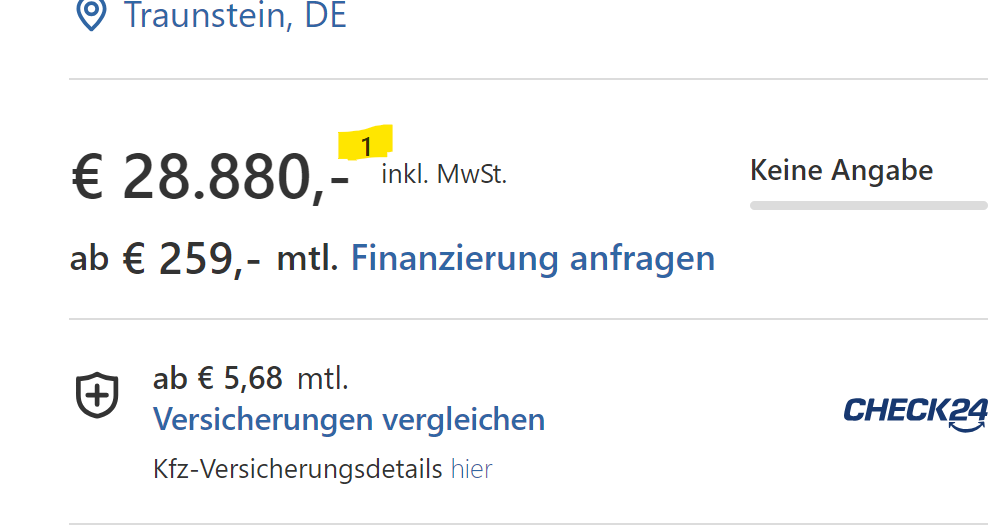


In [29]:
cars_df["Preis"]

0           29181.0
1           11495.0
2            9500.0
4            8400.0
5           65000.0
            ...    
105747    1017001.0
105748    1148301.0
105749    1379001.0
105750    1399001.0
105751    1195501.0
Name: Preis, Length: 103648, dtype: float64

In [30]:
#alle die mit 1 als Zahl enden
selected_samples = cars_df[cars_df["Preis"] % 10 == 1]

selected_samples["Preis"]

0           29181.0
13         479501.0
14         298751.0
15         669851.0
16         269801.0
            ...    
105747    1017001.0
105748    1148301.0
105749    1379001.0
105750    1399001.0
105751    1195501.0
Name: Preis, Length: 49614, dtype: float64

Das Problem ist, was wenn der Preis tatsächlich mit einer 1 aufhört? Deshalb vergleichen wir die Anzahl Zahlen mit dem Barzahlungspreis um keine falschen 1en zu löschen.

In [31]:
cars_df["Barzahlungspreis"]

0         € 29.181,-
1         € 11.495,-
2          € 9.500,-
4          € 8.400,-
5         € 65.000,-
             ...    
105747           NaN
105748           NaN
105749           NaN
105750           NaN
105751           NaN
Name: Barzahlungspreis, Length: 103648, dtype: object

In [32]:
def convert_to_float(price_str):
    try:
        # Überprüfe, ob der Typ der Zeichenkette str ist
        if isinstance(price_str, str):
            # Extrahiere nur die Zahlen aus der Zeichenkette
            cleaned_str = ''.join(filter(str.isdigit, price_str))

            # Wandle die Zeichenkette in eine Float-Zahl um
            return float(cleaned_str)
        else:
            # Falls der Typ nicht str ist, gib den Wert unverändert zurück
            return price_str
    except (ValueError, TypeError):
        # Handle Fehler, z.B. wenn die Zeichenkette NaN ist
        return None


cars_df["Barzahlungspreis"].apply(convert_to_float)

0         29181.0
1         11495.0
2          9500.0
4          8400.0
5         65000.0
           ...   
105747        NaN
105748        NaN
105749        NaN
105750        NaN
105751        NaN
Name: Barzahlungspreis, Length: 103648, dtype: float64

In [33]:
# Anwendung der Funktion auf die Spalte "Barzahlungspreis"
cars_df["Barzahlungspreis"] = cars_df["Barzahlungspreis"].apply(convert_to_float)

# Ausgabe des aktualisierten DataFrames
cars_df["Barzahlungspreis"]

0         29181.0
1         11495.0
2          9500.0
4          8400.0
5         65000.0
           ...   
105747        NaN
105748        NaN
105749        NaN
105750        NaN
105751        NaN
Name: Barzahlungspreis, Length: 103648, dtype: float64

In [34]:
mask_1_too_much = selected_samples['Preis'].apply(lambda x: len(str(x))-2)
mask_1_too_much

0         5
13        6
14        6
15        6
16        6
         ..
105747    7
105748    7
105749    7
105750    7
105751    7
Name: Preis, Length: 49614, dtype: int64

In [35]:
mask_check = cars_df.loc[selected_samples.index, :][cars_df["Barzahlungspreis"].notna()]["Barzahlungspreis"].apply(lambda x: len(str(x))-2)
mask_check

<ipython-input-35-6943f04dac4d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mask_check = cars_df.loc[selected_samples.index, :][cars_df["Barzahlungspreis"].notna()]["Barzahlungspreis"].apply(lambda x: len(str(x))-2)


0         5
14        5
15        5
18        5
22        5
         ..
105733    5
105734    5
105735    5
105736    5
105739    5
Name: Barzahlungspreis, Length: 37364, dtype: int64

In [36]:
samples_1_to_delete = (mask_1_too_much - mask_check)

In [37]:
samples_1_to_delete

0         0.0
13        NaN
14        1.0
15        1.0
16        NaN
         ... 
105747    NaN
105748    NaN
105749    NaN
105750    NaN
105751    NaN
Length: 49614, dtype: float64

- Samples mit 0 --> diese Preise enden auf 1 und das stimmt, also alles okay
- Samples mit NaN --> müssen wir noch überprüfen gibt keine Barzahlungspreis
- Samples mit 1 --> Hier müssen wir im Dataframe die 1 löschen an letzter Stelle

In [38]:
# Alle Samples mit NaN
samples_with_nan = samples_1_to_delete[samples_1_to_delete.isna()]

# Alle Samples mit dem Wert 1
samples_with_1 = samples_1_to_delete[samples_1_to_delete == 1.0]

# Alle Samples ohne NaN und mit dem Wert 1
samples_with_0 = samples_1_to_delete[samples_1_to_delete == 0]


In [39]:
len(samples_with_nan)

12250

In [40]:
samples_with_1

14        1.0
15        1.0
18        1.0
22        1.0
23        1.0
         ... 
105733    1.0
105734    1.0
105735    1.0
105736    1.0
105739    1.0
Length: 37188, dtype: float64

In [41]:
cars_df["Preis"]

0           29181.0
1           11495.0
2            9500.0
4            8400.0
5           65000.0
            ...    
105747    1017001.0
105748    1148301.0
105749    1379001.0
105750    1399001.0
105751    1195501.0
Name: Preis, Length: 103648, dtype: float64

In [42]:
cars_df.loc[samples_with_1.index, "Preis"]

14        298751.0
15        669851.0
18        774651.0
22        748901.0
23        379901.0
            ...   
105733    963901.0
105734    799901.0
105735    948801.0
105736    929001.0
105739    994801.0
Name: Preis, Length: 37188, dtype: float64

In [43]:
cars_df.loc[samples_with_1.index, "Preis"] = cars_df.loc[samples_with_1.index, "Preis"].apply(lambda x: float(str(x)[:-3]))

In [44]:
cars_df.loc[samples_with_1.index, "Preis"]

14        29875.0
15        66985.0
18        77465.0
22        74890.0
23        37990.0
           ...   
105733    96390.0
105734    79990.0
105735    94880.0
105736    92900.0
105739    99480.0
Name: Preis, Length: 37188, dtype: float64

Wir sehen die 1 ist weg.

Bei diesen 12250 Samples wissen wir noch nicht ob sie eine 1 zu viel haben. Schauen wir uns diese mal an:

In [52]:
cars_df.loc[samples_with_nan.index,:]

,url,Country,Date,Marke,Modell,Barzahlungspreis,Anzahlung,Laufzeit,Nettodarlehen,Effektiver Jahreszins,...,Elektrische Reichweite (WLTP),Stromverbrauch (WLTP)2,Elektrische Reichweite7,"€ 3.000,-","€ 4.500,-",Elektrische Reichweite (WLTP)7,"€ 3.500,-","€ 5.500,-","€ 2.400,-","€ 5.000,-"
13,/angebote/volkswagen-amarok-amarok-2-0-tdi-4m-...,Deutschland,2023-12-10 12:09:51.041821,volkswagen,amarok,NaN,"€ 0,-",36 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,/angebote/volkswagen-amarok-amarok-4m-2-0-tdi-...,Deutschland,2023-12-10 12:09:53.516493,volkswagen,amarok,NaN,"€ 14.824,03",48 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,/angebote/volkswagen-amarok-3-0-tdi-4m-aventur...,Deutschland,2023-12-10 12:09:56.860142,volkswagen,amarok,NaN,"€ 7.132,53",36 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,/angebote/volkswagen-amarok-panamericana-3-0-t...,Deutschland,2023-12-10 12:09:57.480365,volkswagen,amarok,NaN,"€ 0,-",60 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,/angebote/volkswagen-amarok-amarok-3-0-tdi-v6-...,Deutschland,2023-12-10 12:10:47.674408,volkswagen,amarok,NaN,"€ 999,-",36 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105747,/angebote/porsche-taycan-innodrive-performance...,Deutschland,2023-12-09 16:57:16.805113,porsche,taycan,NaN,"€ 4.398,-",36 Monate,NaN,NaN,...,501 km,"20,6 kWh/100 km (komb.)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105748,/angebote/porsche-taycan-sport-turismo-luftfed...,Deutschland,2023-12-09 16:57:17.222586,porsche,taycan,NaN,"€ 0,-",48 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105749,/angebote/porsche-taycan-4s-cross-turismo-elek...,Deutschland,2023-12-09 16:57:17.723808,porsche,taycan,NaN,"€ 2.387,05",48 Monate,NaN,NaN,...,452 km,"23,4 kWh/100 km (komb.)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105750,/angebote/porsche-taycan-gts-hockenheimring-ed...,Deutschland,2023-12-09 16:57:18.737742,porsche,taycan,NaN,"€ 4.000,-",48 Monate,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Leider besteht keine Möglichkeit herauszufinden ob das 1 am ende des Preises tatsächlich stimmt oder aufgrund der MWST hinzugefügt wurde. Um keine falschen Labels zu haben, entscheiden wir uns diese ca. 12000 Samples zu löschen.

In [53]:
cars_df = cars_df.drop(samples_with_nan.index, axis=0)

In [54]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91398 entries, 0 to 105739
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             91398 non-null  object 
 1   Country                         91398 non-null  object 
 2   Date                            91398 non-null  object 
 3   Marke                           91398 non-null  object 
 4   Modell                          91398 non-null  object 
 5   Barzahlungspreis                82387 non-null  float64
 6   Anzahlung                       91336 non-null  object 
 7   Laufzeit                        91336 non-null  object 
 8   Nettodarlehen                   82387 non-null  object 
 9   Effektiver Jahreszins           82387 non-null  object 
 10  Sollzins geb. p.a.              82387 non-null  object 
 11  Monatliche Rate                 91336 non-null  object 
 12  Karosserieform                 

Kurzer Check ob wir Duplikate haben:

In [65]:
cars_df["url"].value_counts().max()

1

# Export

In [67]:
# Neuer Index

cars_df.reset_index(drop=True, inplace=True)
cars_df

,url,Country,Date,Marke,Modell,Barzahlungspreis,Anzahlung,Laufzeit,Nettodarlehen,Effektiver Jahreszins,...,Elektrische Reichweite (WLTP),Stromverbrauch (WLTP)2,Elektrische Reichweite7,"€ 3.000,-","€ 4.500,-",Elektrische Reichweite (WLTP)7,"€ 3.500,-","€ 5.500,-","€ 2.400,-","€ 5.000,-"
0,/angebote/volkswagen-181-zivile-ausfuehrung-gu...,Deutschland,2023-12-10 12:09:28.327713,volkswagen,181,29181.0,"€ 0,-",60 Monate,"€ 29.181,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/angebote/volkswagen-181-kuebel-benzin-rot-e45...,Deutschland,2023-12-10 12:09:28.819334,volkswagen,181,11495.0,"€ 0,-",60 Monate,"€ 11.495,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/angebote/volkswagen-181-benzin-gruen-c47cf7af...,Deutschland,2023-12-10 12:09:29.293417,volkswagen,181,9500.0,"€ 0,-",60 Monate,"€ 9.500,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/angebote/volkswagen-181-kuebelwagen-the-thing...,Deutschland,2023-12-10 12:09:30.341151,volkswagen,181,8400.0,"€ 0,-",36 Monate,"€ 8.400,-","5,68 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/angebote/volkswagen-181-vw-kuebel-typ-82-benz...,Deutschland,2023-12-10 12:09:30.967970,volkswagen,181,65000.0,"€ 0,-",48 Monate,"€ 65.000,-","5,99 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91393,/angebote/porsche-taycan-led-navi-360-leder-pa...,Deutschland,2023-12-09 16:57:09.705966,porsche,taycan,79990.0,"€ 0,-",36 Monate,"€ 79.990,-","5,99 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91394,/angebote/porsche-taycan-sport-turismo-frozenb...,Deutschland,2023-12-09 16:57:10.139013,porsche,taycan,94880.0,"€ 0,-",36 Monate,"€ 94.880,-","8,99 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91395,/angebote/porsche-taycan-performance-privacy-c...,Deutschland,2023-12-09 16:57:10.888807,porsche,taycan,92900.0,"€ 2.387,05",48 Monate,"€ 92.900,-","8,99 %",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91396,/angebote/porsche-taycan-turbo-matrix-pano-sou...,Deutschland,2023-12-09 16:57:11.364181,porsche,taycan,NaN,"€ 2.367,73",36 Monate,NaN,NaN,...,410 km,26 kWh/100 km (komb.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
cars_df.to_csv('German_Cars_Data.csv', index=True,  sep=";")

from google.colab import files
files.download('German_Cars_Data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>